In [1]:
import os
import json
#from dadk.BinPol import *
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
from IPython.display import display, HTML
import numpy as np
import seaborn as sns
import scipy as sp
from scipy.stats import gamma
import tqdm



## Problem: Partion Problem



As an initial problem we study the number partitioning problem. Given a set $S$ of $N$ positive numbers 
$S = \{ n_{0}, \ldots , n_{N-1}\}$, is there a partition of $S$ into $P$ disjoint subsets $\{ R_0, \ldots , R_{P-1} \}$, such that the sum of values in 
each set is the same. I.e., can a set of $N$ assets with values $n_0, \ldots , n_{N-1}$ fairly be distributed between $P$ parties?

The Quadratic Unconstrained Binary Optimization model can be formulated in the following way

\begin{align}
	H = \sum_{p=0}^{P-1}  \left( \sum_{i=0}^{N-1} n_{i} x_{i, p} - \frac{1}{P} \sum_{i=0}^{N-1} n_{i} \right)^2 + M \sum_{i=0}^{N-1}  \left( 1- \sum_{p=0}^{P-1} x_{i, p} \right)^2 \, ,
\end{align}

and the decision variable $x_{i, p} \in \{0,1\}$ is defined as

\begin{align}
	x_{i, p} = 
    \begin{cases}
	1 & \text{if number } n_i \text{ of set } S \text{ is in set } R_p \\
	0 & \text{else}
    \end{cases} \, .
\end{align}

- $P=4$: Number of subsets.
- $N$: Number of values in set $S$.
- ${\rm{bits}} = N \cdot P$: Number of bits needed to represent problem QUBO.
- $M$: Penalty factor.

#### Test scenario:
For each case with $N=[16, 32, 48, 64, 80, 96, 112, 128, 160, 192, 224, 256, 320, 384, 448, 512, 640, 768, 896, 1024]$, 8 problem instances have been generated with a different random seed ($\rm{value-seed}$). Values are in $[1, 1000]$, and values are generated such that the sum of values in $S$ is a multiple of $P=4$.
For each case and each problem instance, 8 DA calls with 128 runs and different random seeds ($\rm{da-seed}$) have been exectued in order to have 8 independent optimizations. The number of DA iterations has been chosen $\rm{bits^2}$. Automatic temperature tuning has been selected. Th penalty factor $M$ varies from $25,000$ to $250,000$ in steps of $10^{i /32}$ with $i=[0, 1, ..., 32]$.

For each instance, $N$ values is $S$ are uniformly generated in the interval $[0,1000]$, then they are slightly adjusted to make the total sum divisible by $P$.

## Read data for analysis

We first condense the information and create files `bits-short.json`. These files are of the form
- `{M: {value-seed-da-seed: [[energy objective, energy penalty], ...]}, ...}`
- for example: `{"25000": {"42-42": [[19030, 0], ...]}, ...}`


We read in the data stored in the files `results-N={N}_P={P}-short.json`. The resulting multidimensional array `data[N_idx, M_idx, value-seed_idx, da-seed_idx, run, obj_or_pen]` can be adressed with *INDEX* parameters $N_{idx}$ ($0,\dots,12$), $M_{idx}$ ($0,\dots,98$), $\rm{vaule-seed}_{idx}$ ($0,\dots,3$), $\rm{da-seed}_{idx}$ ($0,\dots,3$) and $\rm{run}$ ($0,\dots,127$). Such indexed array contains a pair of energies: [objective energy, penalty energy] .

A similar structure is valid for `data_temp`, which stored the (initial and final) temperature at which the DA operated. The array values can be accessed via `data_temp[N_idx, M_idx, value-seed_idx, da-seed_idx, start_or_end]` where the last index is $0$ for the initial temperature of the annealing and $1$ for the final (hence the sampling probability).

In [2]:
## Dataset 

colors = sns.color_palette("Paired", 12)


Ps = np.arange(2,15)
Ns = 8*Ps
Ms = np.concatenate( (np.arange(50_000, 100_000, 1_000), np.array([int(10**5 * 2 ** (i / 32)) for i in range(49)])))
n_vseeds = 4
n_dseeds = 4
runs = 128
seeds = np.array([42, 43, 44, 45])

Ns

array([ 16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96, 104, 112])

In [5]:

### open files and fill data structures with data

directory = "../data/scan_NPP/"

data = np.ndarray(shape = (len(Ns), len(Ms), n_vseeds, n_dseeds, runs, 2))
data_temp = np.ndarray(shape = (len(Ns), len(Ms), n_vseeds, n_dseeds, 2)) # the final index is 0 for starting temperature, 1 for final temperature

for N_idx, N in enumerate(Ns):
    P = Ps[N_idx]
    bits = P*N    
    filename = directory + f'results-N={N}_P={P}-short.json'
    if not os.path.isfile(filename):
        print(f"{filename} doesn't exist")
        continue        

    with open(filename, 'r') as fp:
        summary = json.load(fp)
        summary = {int(M):{seed:summary[M][seed] for seed in summary[M]} for M in sorted(list(summary.keys()))}
        
        seed_ids = []
        for M in sorted(list(summary.keys())):
            for seed_id in summary[M]:
                if seed_id not in seed_ids:
                    seed_ids.append(seed_id)
        seed_ids = sorted(list(set(seed_ids)))
        vseeds = sorted(list(set([seed_id.split('-')[0] for seed_id in seed_ids])))
        daseeds = sorted(list(set([seed_id.split('-')[1][:2] for seed_id in seed_ids])))

        assert len(vseeds) == n_vseeds and len(daseeds) == n_dseeds

        for M_idx, M in enumerate(sorted( list(summary.keys()) )):
            for vseed_idx, vseed in enumerate(vseeds):
                for daseed_idx, daseed in enumerate(daseeds):
                    ener_key = str(vseed) + "-" + str(daseed)
                    t_key = ener_key + "_data"
                    data[N_idx, M_idx, vseed_idx, daseed_idx] = summary[M][ener_key]
                    data_temp[N_idx, M_idx, vseed_idx, daseed_idx, 0] = summary[M][t_key]["temperature_start"]
                    data_temp[N_idx, M_idx, vseed_idx, daseed_idx, 1] = summary[M][t_key]["temperature_end"]

        print(f'Read data --> {N:,d} values, {P} sets, {bits:,d} bits, {bits*bits:,d} iterations --> Done')

Read data --> 16 values, 2 sets, 32 bits, 1,024 iterations --> Done
Read data --> 24 values, 3 sets, 72 bits, 5,184 iterations --> Done
Read data --> 32 values, 4 sets, 128 bits, 16,384 iterations --> Done
Read data --> 40 values, 5 sets, 200 bits, 40,000 iterations --> Done
Read data --> 48 values, 6 sets, 288 bits, 82,944 iterations --> Done
Read data --> 56 values, 7 sets, 392 bits, 153,664 iterations --> Done
Read data --> 64 values, 8 sets, 512 bits, 262,144 iterations --> Done
Read data --> 72 values, 9 sets, 648 bits, 419,904 iterations --> Done
Read data --> 80 values, 10 sets, 800 bits, 640,000 iterations --> Done
Read data --> 88 values, 11 sets, 968 bits, 937,024 iterations --> Done
Read data --> 96 values, 12 sets, 1,152 bits, 1,327,104 iterations --> Done
Read data --> 104 values, 13 sets, 1,352 bits, 1,827,904 iterations --> Done
Read data --> 112 values, 14 sets, 1,568 bits, 2,458,624 iterations --> Done


In [25]:
### SANITY CHECK: check integrity of the data, parameters are all as expected, with asserts: 
#           #_iter = n**2       temp_mode = 0 (exponential)        temp_interval = N)

for N_idx, N in enumerate(Ns):
    P = Ps[N_idx]
    bits = P*N    
    filename = f'results-N={N}_P={P}-short.json'
    if not os.path.isfile(filename):
        print(f"{filename} doesn't exist")
        continue        

    with open(filename, 'r') as fp:
        summary = json.load(fp)
        summary = {int(M):{seed:summary[M][seed] for seed in summary[M]} for M in sorted(list(summary.keys()))}
        
        seed_ids = []
        for M in sorted(list(summary.keys())):
            for seed_id in summary[M]:
                if seed_id not in seed_ids:
                    seed_ids.append(seed_id)
        seed_ids = sorted(list(set(seed_ids)))
        vseeds = sorted(list(set([seed_id.split('-')[0] for seed_id in seed_ids])))
        daseeds = sorted(list(set([seed_id.split('-')[1][:2] for seed_id in seed_ids])))

        assert len(vseeds) == n_vseeds and len(daseeds) == n_dseeds

        for M in list(summary.keys()):
            for vseed in vseeds:
                for daseed in daseeds:
                    key = str(vseed) + "-" + str(daseed) + "_data"
                    assert summary[M][key]["number_runs"] == 128
                    assert summary[M][key]["number_iterations"] == bits**2
                    assert summary[M][key]["temperature_mode"] == 0
                    assert summary[M][key]["temperature_interval"] == N                  

In [ ]:
### useful functions

def nearest_to(ref_array, element):
    """
    Given a requested element (e.g. energy), returns the nearest value in a reference array, together with its position in the array
    """
    diff = np.abs(ref_array - element)
    idx = np.where(diff == np.min(diff))[0][0]
    return idx, ref_array[idx]


def compute_valnrate_forM(data_NM):
    """
    For a given N and M, returns the obj value of feasible points, together with the feasibility rate
    """
    feasible = (data_NM[..., 1] == 0)
    sum = data_NM[..., 1] + data_NM[..., 0]
    counter = n_vseeds*n_dseeds*runs
    values = np.array([sum.flatten()[j] for j in range(counter) if feasible.flatten()[j]])
    rate = 100*len(values)/counter
    return values, rate, counter

def compute_rate_forM(data_NM):
    """
    For a given N and M, returns the obj value of feasible points, together with the feasibility rate
    """
    feasible = (data_NM[..., 1] == 0)
    rate = 100*np.sum(feasible)/(n_vseeds*n_dseeds*runs)
    return rate


def compute_rate_forM_forinst(data_NM):
    """
    For a given N and M, returns the obj value of feasible points, together with the feasibility rate
    """
    feasible = (data_NM[..., 1] == 0)
    rate = 100*np.sum(feasible)/(n_dseeds*runs)
    return rate


def bootstrap(values, total, bs_size = 5):
    """
    Bootstraps the feasible value obtained (values) with a certain size. Returns success rate of bootstrapping and mean of the bests.
    """
    values = np.concatenate((values, -100*np.ones(total - len(values))))
    np.random.shuffle(values)

    n_straps = total // bs_size
    bests = []
    success = 0
    for i in range(n_straps):
        v = values[i*bs_size : (i+1)*bs_size]
        if np.any(v >= 0):
            success += 1
            bests.append(min(v[v>=0]))

    succ_rate = 100*success/n_straps
    return succ_rate, np.mean(bests)

def L1_norm(Q, const):
    return const + np.sum(np.abs(Q))

def L1_norm_hot(Q, const, n_bits, temperature, max_prob_inf):
    return L1_norm(Q, const) + temperature*(n_bits*np.log(2) - np.log(max_prob_inf))

## D.A. temperature

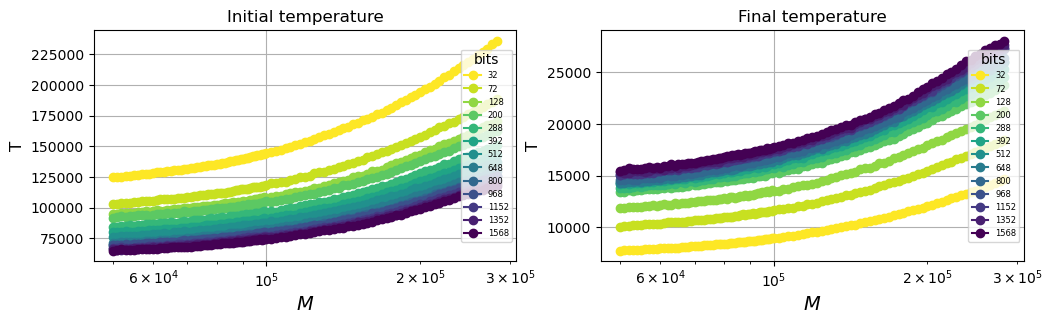

In [6]:
def plot_temperature(data_temp):
    colormap = plt.cm.viridis.reversed()
    discr_colors = ListedColormap(colormap(np.linspace(0, 1, len(Ns)))) 

    fig = plt.figure(figsize=(12, 3))
    ax = fig.add_subplot(1, 2, 1)

    # plot
    for N_idx, N in enumerate(Ns):
        ax.plot(Ms, np.mean(data_temp[N_idx, :, ..., 0], axis = (1,2)),"-o", color = discr_colors.colors[N_idx], label = f'{N*Ps[N_idx]}')
    ax.set_ylabel("T", fontsize=12)
    ax.set_xlabel(r"$M$",fontsize=14)
    ax.legend(fontsize = 6, loc='right', title = "bits")
    ax.set_xticks(10**5*np.array([1, 1.5, 2, 2.5, 3]))
    plt.xscale('log')
    ax.set_title("Initial temperature")
    plt.grid()

    ax = fig.add_subplot(1, 2, 2)

    # plot
    for N_idx, N in enumerate(Ns):
        ax.plot(Ms, np.mean(data_temp[N_idx, :, ..., 1], axis = (1,2)),"-o", color = discr_colors.colors[N_idx], label = f'{N*Ps[N_idx]}')
    ax.set_ylabel("T", fontsize=12)
    ax.set_xlabel(r"$M$",fontsize=14)
    ax.legend(fontsize = 6, loc='right', title = "bits")
    ax.set_xticks(10**5*np.array([1, 1.5, 2, 2.5, 3]))
    plt.xscale('log')
    ax.set_title("Final temperature")
    plt.grid()

    plt.show()
    return

plot_temperature(data_temp)

## Rates, energies and bootstrap

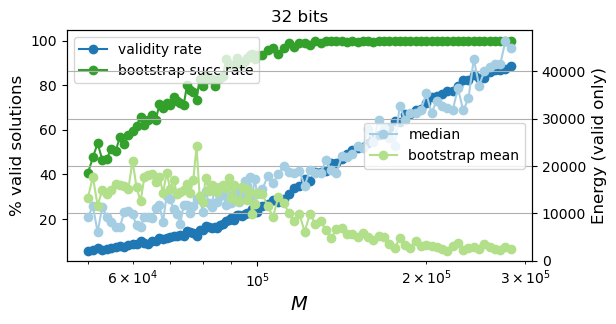

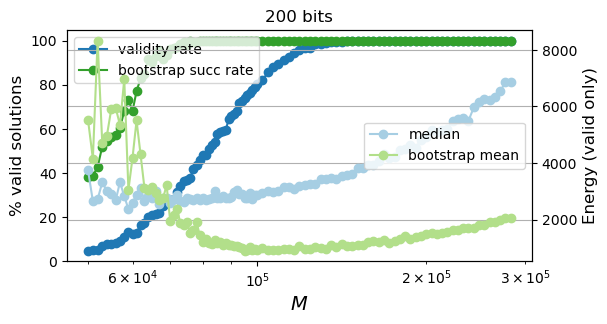

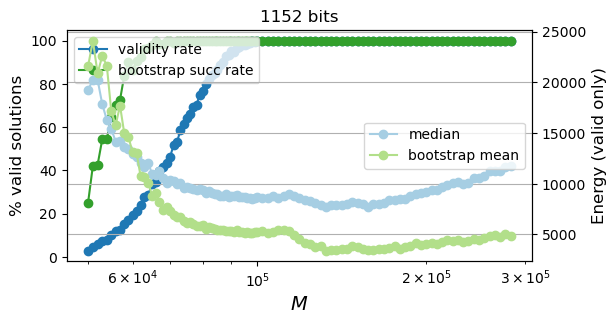

In [7]:
def plot_ener_rates(data_N, N, plot_rate_thr = 10, bs_size = None):
    """
    Computes and plots, as a function of M, median and mean energy, feasibility rate.
    Also, if bs_size is an integer, applies bootstrap and plots success rate and bootstrap mean energy
    """
    fig, ax = plt.subplots(1, 1, figsize=(6,3))
    ax2 = ax.twinx()

    # get data to plot
    means, medians, rates, counts = np.ndarray(len(Ms)), np.ndarray(len(Ms)), np.ndarray(len(Ms)), np.ndarray(len(Ms))
    if bs_size != None:
        bs_succ_rate, bs_best = np.ndarray(len(Ms)), np.ndarray(len(Ms))
    for M_idx, M in enumerate(Ms):
        values, rates[M_idx], total = compute_valnrate_forM(data_N[M_idx])
        counts[M_idx] = len(values)
        
        if counts[M_idx] > 0:
            means[M_idx], medians[M_idx] = np.mean(values), np.median(values)
            if bs_size != None:
                bs_succ_rate[M_idx], bs_best[M_idx] = bootstrap(values, total, bs_size = bs_size)

    # plot
    ax.plot(Ms, rates,"-o", color = colors[1], label = 'validity rate')
    mask = [r and c for r,c in zip(rates > plot_rate_thr, counts > 0)]
    #ax2.plot( Ms[mask], means[mask],"-o", c=colors[1], label = 'mean')
    ax2.plot( Ms[mask], medians[mask],"-o", c=colors[0], label = 'median')
    if bs_size != None:
        ax2.plot( Ms[mask], bs_best[mask],"-o", c=colors[2], label = 'bootstrap mean')
        ax.plot( Ms[mask], bs_succ_rate[mask],"-o", c=colors[3], label = 'bootstrap succ rate') 

    # refines plot
    ax2.set_ylabel("Energy (valid only)", fontsize=12)
    ax.set_ylabel("% valid solutions", fontsize=12)
    ax.set_xlabel(r"$M$",fontsize=14)
    ax2.legend(fontsize = 10, loc='center right')
    ax.legend(fontsize = 10, loc='upper left')
    N_idx = np.where(Ns == N)[0][0]
    plt.title(f"{N*Ps[N_idx]} bits")
    plt.xscale('log')
    #plt.yscale('log')
    plt.grid()
    plt.show()
    return


for N in [16, 40, 96]:
    N_idx = np.where(Ns == N)[0][0]
    display(HTML(f"<h3>{N:,d} elements in set, {Ps[N_idx]} subsets, {N*Ps[N_idx]:,d} bits"))
    #print_table(N, data)

    plot_rate_thr = 1
    bootstrap_size = 10
    plot_ener_rates(data[N_idx], N, plot_rate_thr, bs_size = bootstrap_size)
        

## Rates and phase transition

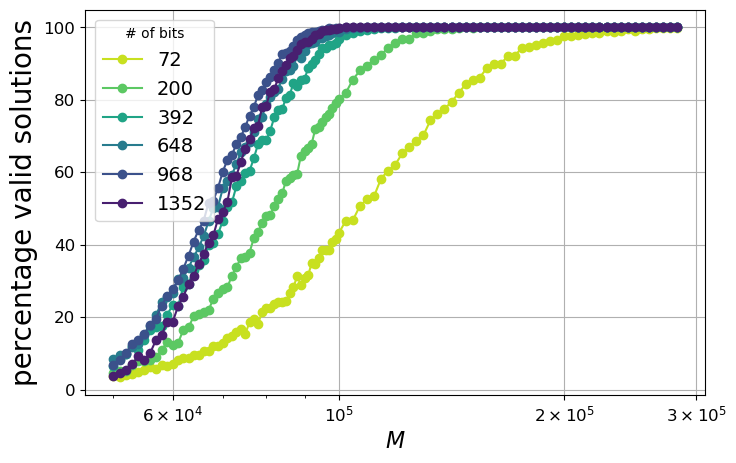

In [19]:
def plot_rates(data):
    fig, ax = plt.subplots(1, 1, figsize=(8,5))

    colormap = plt.cm.viridis.reversed()
    discr_colors = ListedColormap(colormap(np.linspace(0, 1, len(Ns)))) 

    # get data to plot
    rates = np.ndarray((len(Ns),len(Ms)))
    for N_idx in range(len(Ns)):
        for M_idx, M in enumerate(Ms):
            rates[N_idx, M_idx] = compute_rate_forM(data[N_idx, M_idx])

    # plot
    for N_idx in np.arange(1, 13, 2):
        ax.plot(Ms, rates[N_idx],"-o", color = discr_colors.colors[N_idx], label = f'{Ns[N_idx]*Ps[N_idx]}')
    ax.set_ylabel("percentage valid solutions", fontsize=20)
    ax.set_xlabel(r"$M$",fontsize=16)
    ax.legend(fontsize = 14, loc='upper left', title = "# of bits")
    plt.xscale('log')
    ax.set_xticks(10**5*np.array([1, 1.5, 2, 2.5, 3]))
    ax.set_xticks(10**5*np.array([0.6, 1, 2, 3]))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid()
    plt.show()
    return


plot_rates(data)

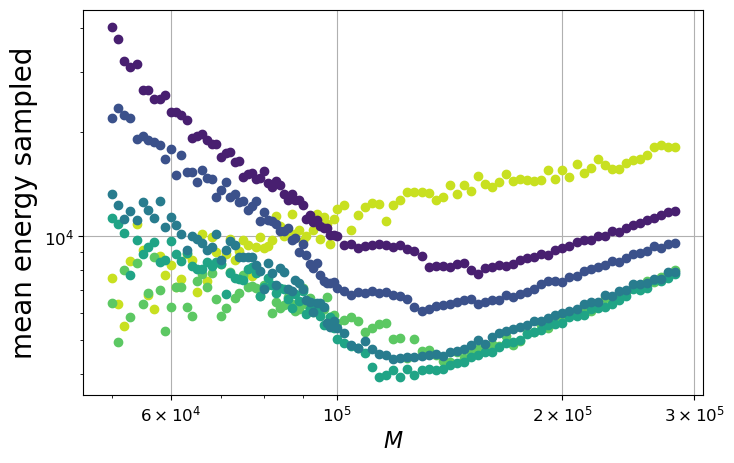

In [32]:
def plot_rates_and_energies(data):
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    colormap = plt.cm.viridis.reversed()
    discr_colors = ListedColormap(colormap(np.linspace(0, 1, len(Ns)))) 

    # get data to plot
    rates, means = np.ndarray((len(Ns),len(Ms))), np.ndarray((len(Ns),len(Ms)))
    for N_idx in range(len(Ns)):
        for M_idx, M in enumerate(Ms):
            values, rates[N_idx, M_idx], _ = compute_valnrate_forM(data[N_idx, M_idx])
            means[N_idx, M_idx] = np.mean(values)

    # plot
    for N_idx in np.arange(1, 13, 2):
        ax.plot(Ms, means[N_idx],"o", color = discr_colors.colors[N_idx], label = f'{Ns[N_idx]*Ps[N_idx]}')
    ax.set_ylabel("mean energy sampled", fontsize=20)
    ax.set_xlabel(r"$M$",fontsize=16)
    #ax.legend(fontsize = 10, loc='upper left', title = "# of bits")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xticks(10**5*np.array([0.6, 1, 2, 3]))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.grid()
    plt.show()
    return


plot_rates_and_energies(data)

In [70]:
### validity rates for single instances


# def plot_rates_instances(data, N_idx, n_inst):
#     dataN = data[N_idx]
#     fig, ax = plt.subplots(1, 1, figsize=(6,3))

#     colormap = plt.cm.viridis.reversed()
#     discr_colors = ListedColormap(colormap(np.linspace(0, 1, n_inst))) 

#     # get data to plot
#     rates = np.ndarray((n_inst,len(Ms)))
#     for i_idx in range(n_inst):
#         for M_idx, M in enumerate(Ms):
#             rates[i_idx, M_idx] = compute_rate_forM_forinst(dataN[M_idx, i_idx])

#     # plot
#     for i_idx in range(n_inst):
#         ax.plot(Ms, rates[i_idx],"-o", color = discr_colors.colors[i_idx], label = i_idx)
#     ax.set_ylabel("% valid solutions", fontsize=12)
#     ax.set_xlabel(r"$M$",fontsize=14)
#     ax.set_title(f"N = {Ns[N_idx]}")
#     ax.legend(fontsize = 10, loc='upper left', title = "instance")
#     plt.xscale('log')
#     ax.set_xticks(10**5*np.array([1, 1.5, 2, 2.5, 3]))
#     plt.grid()
#     plt.show()
#     return

# n_inst = 4
# for N_idx in range(len(Ns)):
#     plot_rates_instances(data, N_idx, n_inst)

## 3d (M - energy) heatmap

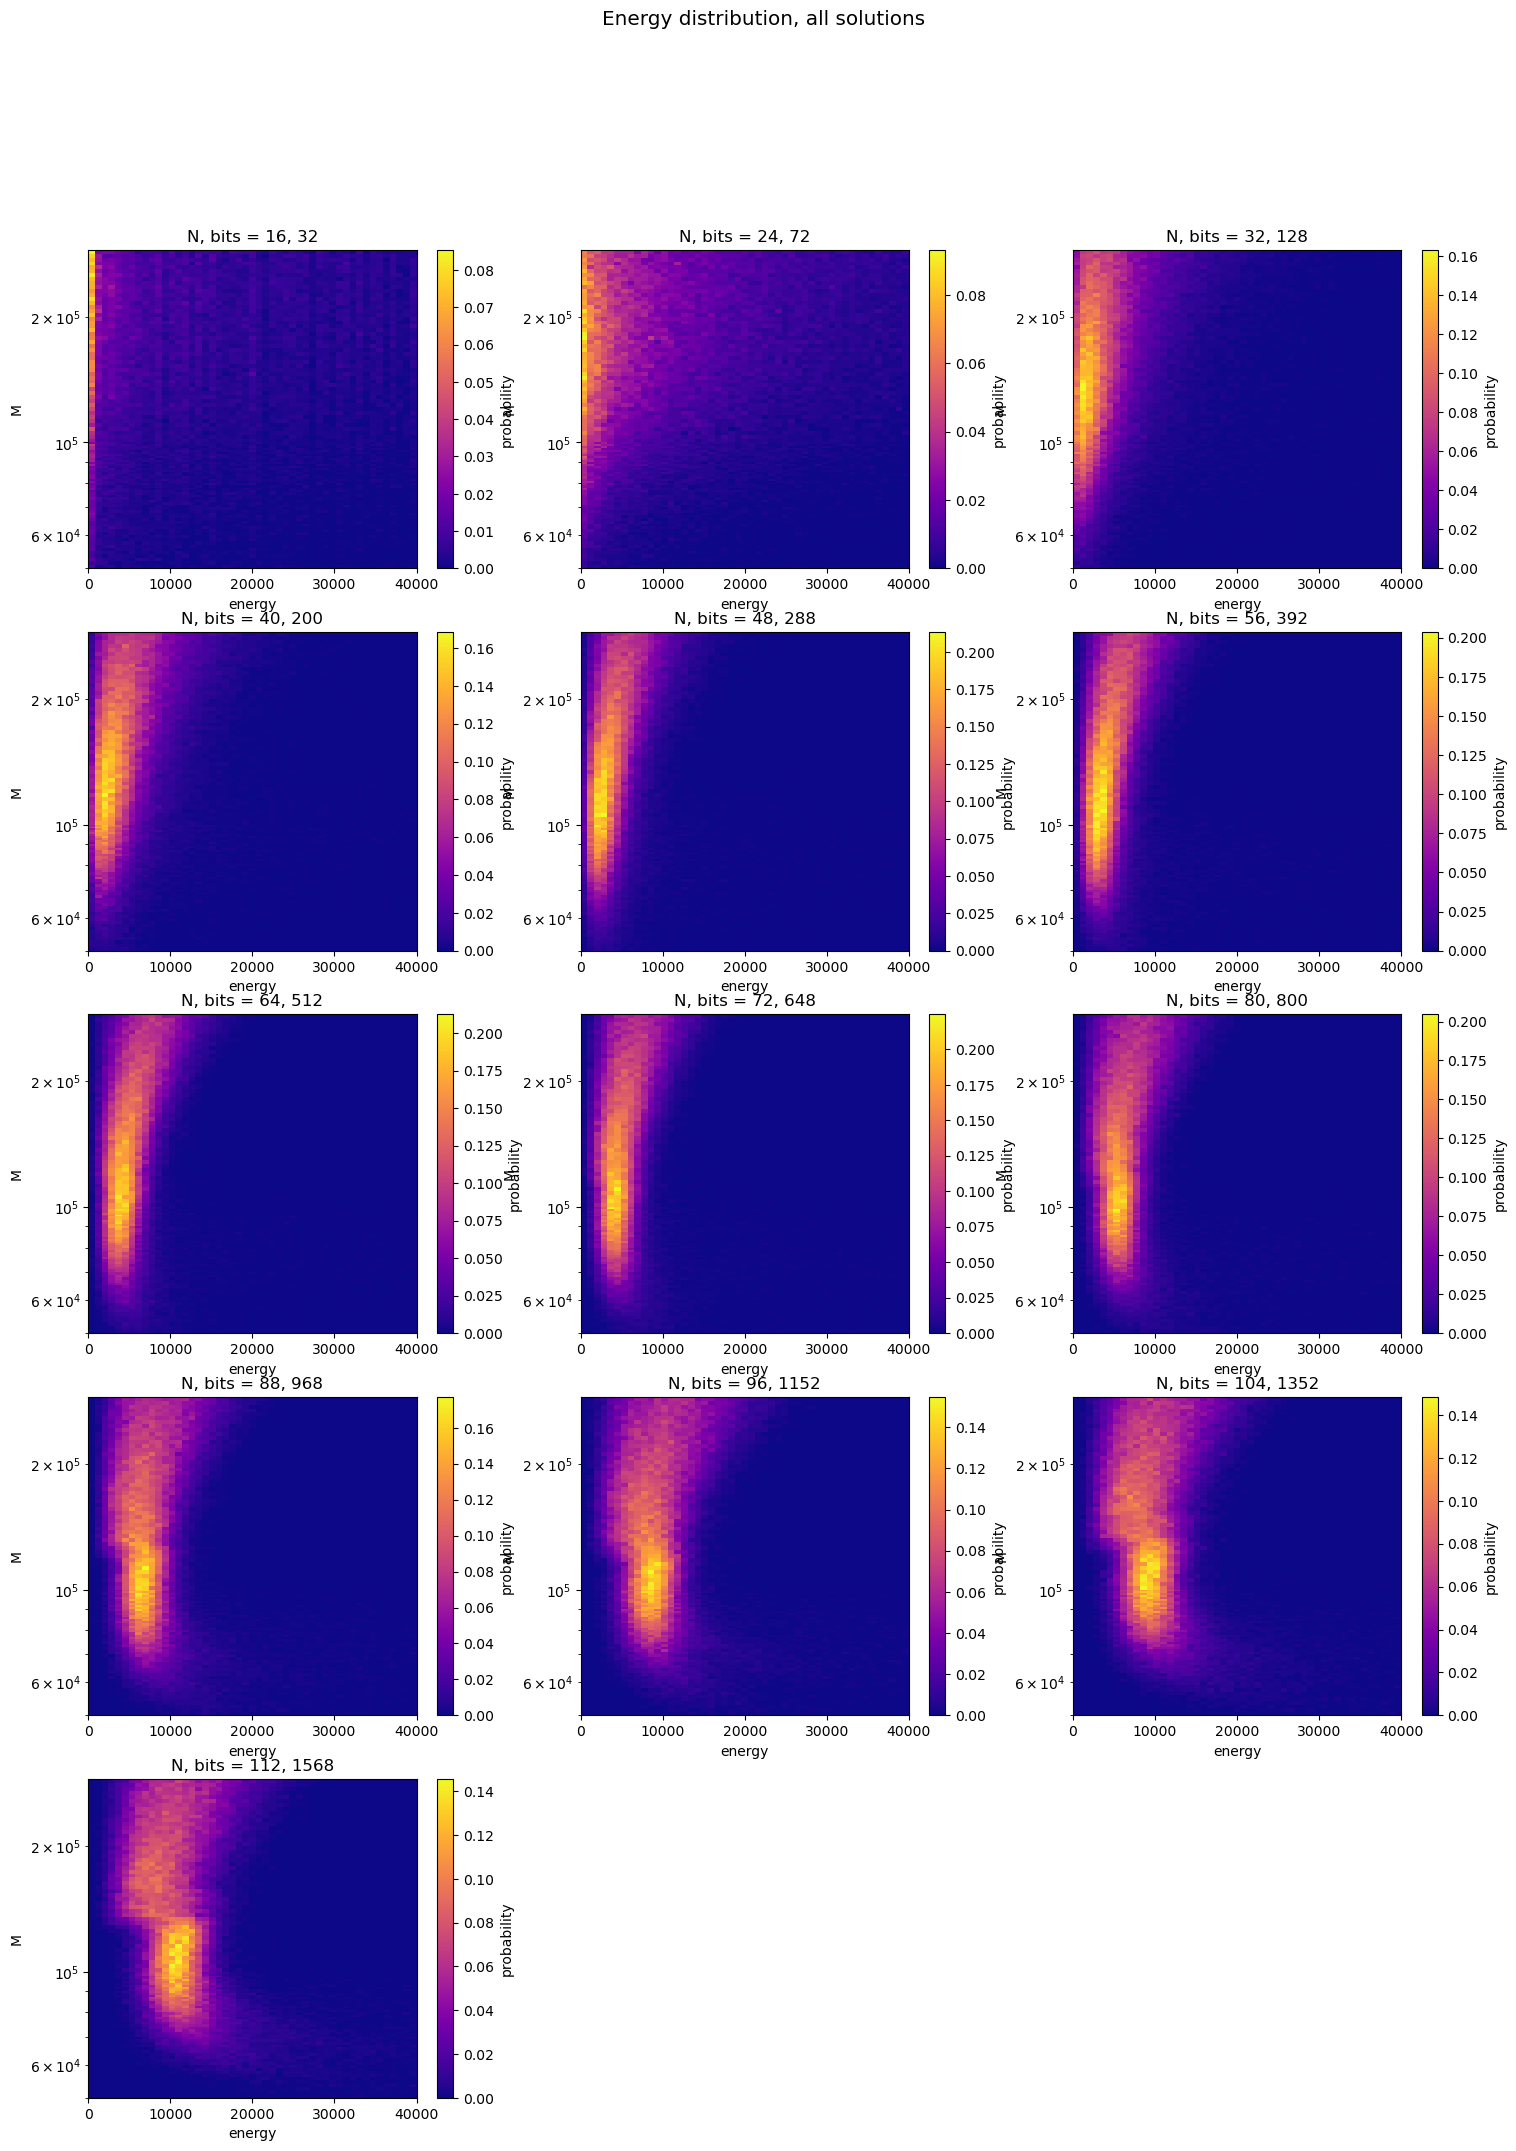

In [71]:
def plot_heatmap_ener(data, N_idx, which, ener_max, bins_ener, fig, plot_code):

    # get data to plot
    data_N = data[N_idx]
    ener = np.reshape(data_N, newshape = (len(Ms), n_vseeds*n_dseeds*runs, 2))
    M_list = np.array([])
    ener_list = np.array([])

    if which == 'valid':
        for M_idx, M in enumerate(Ms):
            valids = ener[M_idx, :, 1] == 0
            M_list = np.append(M_list, M*np.ones((sum(valids))))
            ener_list = np.append(ener_list, ener[M_idx, valids, 0])
    elif which == 'all':
        for M_idx, M in enumerate(Ms):
            M_list = np.append(M_list, M*np.ones(( len(ener[M_idx, :, 0]) )))
            ener_list = np.append(ener_list, ener[M_idx, :, 0] + ener[M_idx, :, 1])
    else:
        raise ValueError("energy histogram to plot not understood")

        # get data in histogram-friendly format
    # set bins limits
    bins_ener = bins_ener
    ener_edges = np.linspace(0, ener_max, num=bins_ener)
    M_edges = np.concatenate((Ms, [Ms[-1]* Ms[-1]/Ms[-2]] )) # artificially add last M point with same log-distance
    # compute histogram 
    hist, xedges, yedges = np.histogram2d(ener_list, M_list, bins=[ener_edges, M_edges])
    dz = hist.T.flatten()
    max_height, min_height = np.max(dz),np.min(dz)

    # heatmap
    total = runs*n_vseeds*n_dseeds
    ax = fig.add_subplot(*plot_code)
    cmap = matplotlib.colormaps['plasma']
    pcm = ax.pcolormesh(xedges, yedges, hist.T/total, cmap=cmap, vmin=min_height/total, vmax=max_height/total)
    #ax.axhline(1.4*10**5, color = "k") # estimated transition point
    cbar = fig.colorbar(pcm, ax=ax)
    ax.set_yscale("log")
    ax.set_ylabel("M")
    ax.set_xlabel("energy")
    ax.set_title(f"N, bits = {Ns[N_idx]}, {Ns[N_idx]*Ps[N_idx]}")
    cbar.set_label('probability')
    return
    


def plot_table_heatmaps(data, which, Ns_toplot, ener_max, bins_ener = 50):
    fig = plt.figure(figsize=(18, 24))
    fig.suptitle(f"Energy distribution, {which} solutions", fontsize="x-large")
    for idx in range(len(Ns_toplot)):
        plot_code = (5, 3, idx+1)
        N_idx = np.where(Ns == Ns_toplot[idx])[0][0]
        plot_heatmap_ener(data, N_idx, which, ener_max, bins_ener, fig, plot_code)

    plt.show()
    return

Ns_toplot = Ns
ener_max = 40000
plot_table_heatmaps(data, 'all', Ns_toplot, ener_max)

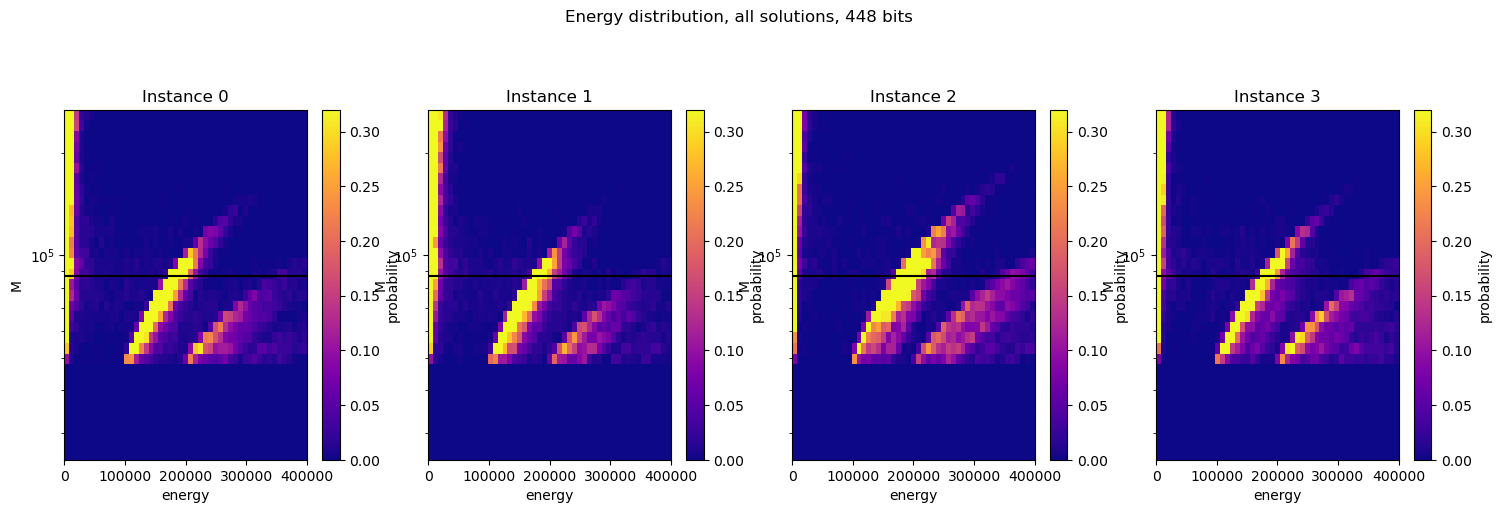

In [72]:
### Single instances heatmap


def plot_heatmap_ener_instance(data_N, i_idx, which, ener_max, bins_ener, fig, plot_code):

    # get data to plot
    data_Ni = data_N[:, i_idx]
    ener = np.reshape(data_Ni, newshape = (len(Ms), n_dseeds*runs, 2))
    M_list = np.array([])
    ener_list = np.array([])

    if which == 'valid':
        for M_idx, M in enumerate(Ms):
            valids = ener[M_idx, :, 1] == 0
            M_list = np.append(M_list, M*np.ones((sum(valids))))
            ener_list = np.append(ener_list, ener[M_idx, valids, 0])
    elif which == 'all':
        for M_idx, M in enumerate(Ms):
            M_list = np.append(M_list, M*np.ones(( len(ener[M_idx, :, 0]) )))
            ener_list = np.append(ener_list, ener[M_idx, :, 0] + ener[M_idx, :, 1])
    else:
        raise ValueError("energy histogram to plot not understood")

        # get data in histogram-friendly format
    # set bins limits
    ener_edges = np.linspace(0, ener_max, num=bins_ener)
    M_edges = np.array([int(25000*10**(i/32)) for i in range(34)])
    # compute histogram 
    hist, xedges, yedges = np.histogram2d(ener_list, M_list, bins=[ener_edges, M_edges])
    xpos, ypos = np.meshgrid(xedges[:-1], (yedges[:-1]+yedges[1:])/2) 
    xpos, ypos = xpos.flatten(), ypos.flatten()
    dz = hist.T.flatten()
    cmap = matplotlib.colormaps['plasma']
    max_height, min_height = np.max(dz),np.min(dz)

    # heatmap
    total = runs*n_dseeds
    ax = fig.add_subplot(*plot_code)
    pcm = ax.pcolormesh(xedges, yedges, hist.T/total, cmap=cmap, vmin=0, vmax=color_lims[N_idx]) #vmin=min_height/total, vmax=max_height/total
    ax.axhline(8.7*10**4, color = "k") # estimated transition point
    cbar = fig.colorbar(pcm, ax=ax)
    ax.set_yscale("log")
    ax.set_ylabel("M")
    ax.set_xlabel("energy")
    ax.set_title(f"Instance {i_idx}")
    cbar.set_label('probability')
    return
    

def plot_table_heatmaps(data_N, which, ener_max, bins_ener = 50):
    fig = plt.figure(figsize=(18, 10))
    fig.suptitle(f"Energy distribution, {which} solutions, {Ns[N_idx]*P} bits")
    for i_idx in range(n_vseeds):
        plot_code = (2, 4, i_idx+1)
        plot_heatmap_ener_instance(data_N, i_idx, which, ener_max, bins_ener, fig, plot_code)
    plt.show()
    return
    

N_idx = 2
color_lims = [0.09, 0.22, 0.32, 0.32, 0.28, 0.23, 0.24, 0.19, 0.2, 0.4, 0.5] # max prob (color), for each N
ener_max = 400000
which = 'all'
plot_table_heatmaps(data[N_idx], which, ener_max)

## 2d histogram and temperatures

Fit:	dim: 5.51	Temp.:	1931
D.A. final Temp.:	22724 +/- 1256.0 (avg over all instances and DA seeds)


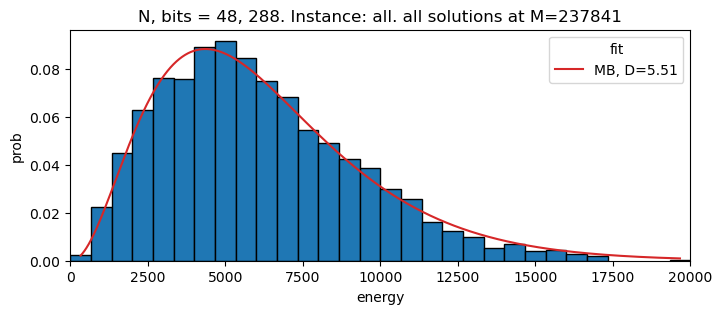

In [14]:
def plot_histo2d_ener_fit(data_N, M, which, bins, fit_lim = None, instance = 'all'):
    '''
    Plot histogram of (all instances of single instance, depending on `instance`) total energies of runs, and fit with MB distribution 
    '''
    M_idx, M = nearest_to(Ms, M)
    # get data to plot
    if instance == 'all':
        ener = np.reshape(data_N[M_idx], newshape = (n_vseeds*n_dseeds*runs, 2))
    else:
        ener = np.reshape(data_N[M_idx, instance], newshape = (n_dseeds*runs, 2))

    if which == 'valid':
        valids = ener[:, 1] == 0
        y_ener = ener[valids, 0]
    elif which == 'all':
        y_ener = ener[:, 0] + ener[:, 1]
    else:
        raise ValueError("energy histogram to plot not understood")
    
    # get histogram data
    counts, x_bins = np.histogram(y_ener, bins = bins, range = (0, 30_000))
    density = counts / counts.sum() # normalize to get a probability
    x_pos = (x_bins[1:] + x_bins[:-1])/2
    bin_width = x_bins[1]-x_bins[0]
    mask = density > 0 # filter out empty bins
    density, x_pos = density[mask], x_pos[mask]

    # plot
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(111)
    ax.bar(x_pos, density, width = bin_width, edgecolor='k', linewidth=1)
    ax.set_ylabel("prob")
    ax.set_xlabel("energy")
    ax.set_xlim(0, 20000)
    plt.title(f"N, bits = {Ns[N_idx]}, {Ns[N_idx]*Ps[N_idx]}. Instance: {instance}. {which} solutions at M={M}")

    # FIT for distribution
    if fit_lim != None:
        start, _ = nearest_to(x_pos, fit_lim[0])
        end, _ = nearest_to(x_pos, fit_lim[1])
        XS = np.linspace(x_pos[start], x_pos[end], 10000)

        ### GAMMA distribution
        f = lambda x, D, beta : gamma.pdf(x, (D+1)/2, loc = 0, scale = 1/beta) * bin_width
        coef, coef_var = sp.optimize.curve_fit(f, x_pos[start:end+1], density[start:end+1], p0 = [5, 1e-3])
        ax.plot(XS, f(XS, *coef), color = "C3", label = f"MB, D={np.round(coef[0], 2)}")
        print(f"Fit:\tdim: {np.round(coef[0], 2)}\tTemp.:\t{int(1/coef[1])}")

        if instance == 'all':
            print(f"D.A. final Temp.:\t{int(np.mean(data_temp[N_idx, M_idx, :, :, 1], axis = (0,1)))} +/- {np.round(np.std(data_temp[N_idx, M_idx, :, :, 1], axis = (0,1)), 0)}" +
                   " (avg over all instances and DA seeds)")
        else:
            print(f"D.A. final Temp.:\t{int(np.mean(data_temp[N_idx, M_idx, instance, :, 1]))} +/- {np.round(np.std(data_temp[N_idx, M_idx, instance, :, 1]))}" +
                   " (single instance, avg over DA seeds)")
    ax.legend(fontsize = 10, loc='best', title = "fit")
    plt.show()
    return


M = 2.4*10**5
N_idx = 4
#bins = 500
bins = "auto"
fit_lim = [0, 20000]
which = 'all'
instance = 'all'
plot_histo2d_ener_fit(data[N_idx], M, which, bins, fit_lim, instance)

# ###
# ### Plot histogram for single instances
# ###
# for j in range(n_vseeds):
#     plot_histo2d_ener_fit(data[N_idx], M, which, bins, fit_lim, j)

## Compare temperatures: fitted vs D.A. input

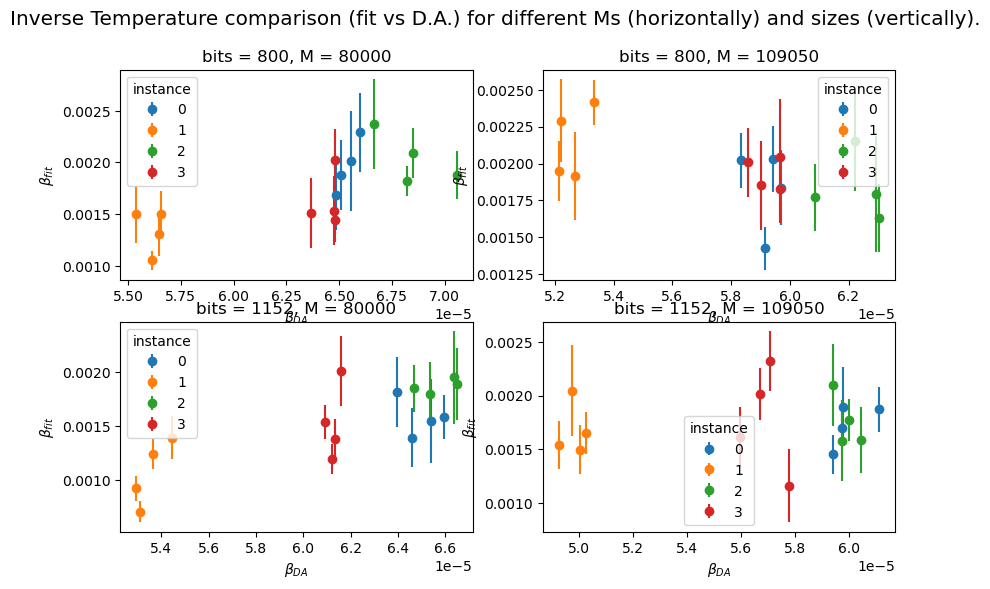

In [ ]:
### Beta_fit and Beta_DA correlation (for chosen M)

def get_beta_fit(data_NM_inst_seed, which, bins, fit_lim):
    '''
    Given energies at given N, M, instance (vseed) and DA initialization (dseed), fit MB at given dimension and return fitted temperature and associated error
    '''
    # get data ready
    ener = np.reshape(data_NM_inst_seed, newshape = (runs, 2))
    if which == 'valid':
        valids = ener[:, 1] == 0
        y_ener = ener[valids, 0]
    elif which == 'all':
        y_ener = ener[:, 0] + ener[:, 1]
    else:
        raise ValueError("energy histogram to plot not understood")
    
    # get histogram data
    counts, x_bins = np.histogram(y_ener, bins = bins, range = (0, 30_000))
    density = counts / counts.sum() # normalize to get a probability
    x_pos = (x_bins[1:] + x_bins[:-1])/2
    bin_width = x_bins[1]-x_bins[0]
    mask = density > 0 # filter out empty bins
    density, x_pos = density[mask], x_pos[mask]

    # FIT for distribution
    start, _ = nearest_to(x_pos, fit_lim[0])
    end, _ = nearest_to(x_pos, fit_lim[1])
    f = lambda x, D, beta : gamma.pdf(x, (D+1)/2, loc = 0, scale = 1/beta) * bin_width
    coef, coef_var = sp.optimize.curve_fit(f, x_pos[start:end+1], density[start:end+1], p0 = [5, 1e-3])
    return coef[1], np.sqrt(coef_var[1,1])


def plot_temps(data_N, M, N_idx, which, bins, plot_code, fit_lim, fig):
    '''
    Plot fitted vs DA temperatures for different instances (vseed) and DA initializations (dseed)
    '''
    M_idx, M = nearest_to(Ms, M)
    ax = fig.add_subplot(*plot_code)
    for idx_inst in range(n_vseeds):
        # get betas
        beta_fit, beta_fit_err = np.ndarray((n_dseeds)), np.ndarray((n_dseeds))
        for j in range(n_dseeds):
            beta_fit[j], beta_fit_err[j] = get_beta_fit(data_N[M_idx, idx_inst, j], which, bins, fit_lim)
        beta_DA = 1/data_temp[N_idx, M_idx, idx_inst, :, 1]
        # plot
        ax.errorbar(beta_DA, beta_fit, yerr = beta_fit_err, fmt='o', color = f"C{idx_inst}", label = str(idx_inst))

    ax.set_xlabel(r"$\beta_{DA}$")
    ax.set_ylabel( r"$\beta_{fit}$")
    #ax.set_xscale("log")
    ax.legend(fontsize = 10, loc='best', title = "instance")
    plt.title(f"bits = {Ns[N_idx] * Ps[N_idx]}, M = {M}")
    return
    
    

which = 'all'
plot_Ms = [.8*10**5, 1.1*10**5]
plot_Ns_idxs = [8, 10]
bins = "auto"
fit_lim = [0, 20000]

fig = plt.figure(figsize=(10, 6))
fig.suptitle(f"Inverse Temperature comparison (fit vs D.A.) for different Ms (horizontally) and sizes (vertically).", fontsize="x-large")
for idx, N_idx in enumerate(plot_Ns_idxs):
    for M_idx, M in enumerate(plot_Ms):
        plot_code = (len(plot_Ns_idxs), len(plot_Ms), len(plot_Ms)*idx + M_idx + 1)
        plot_temps(data[N_idx], M, N_idx, which, bins, plot_code, fit_lim, fig)
plt.show()

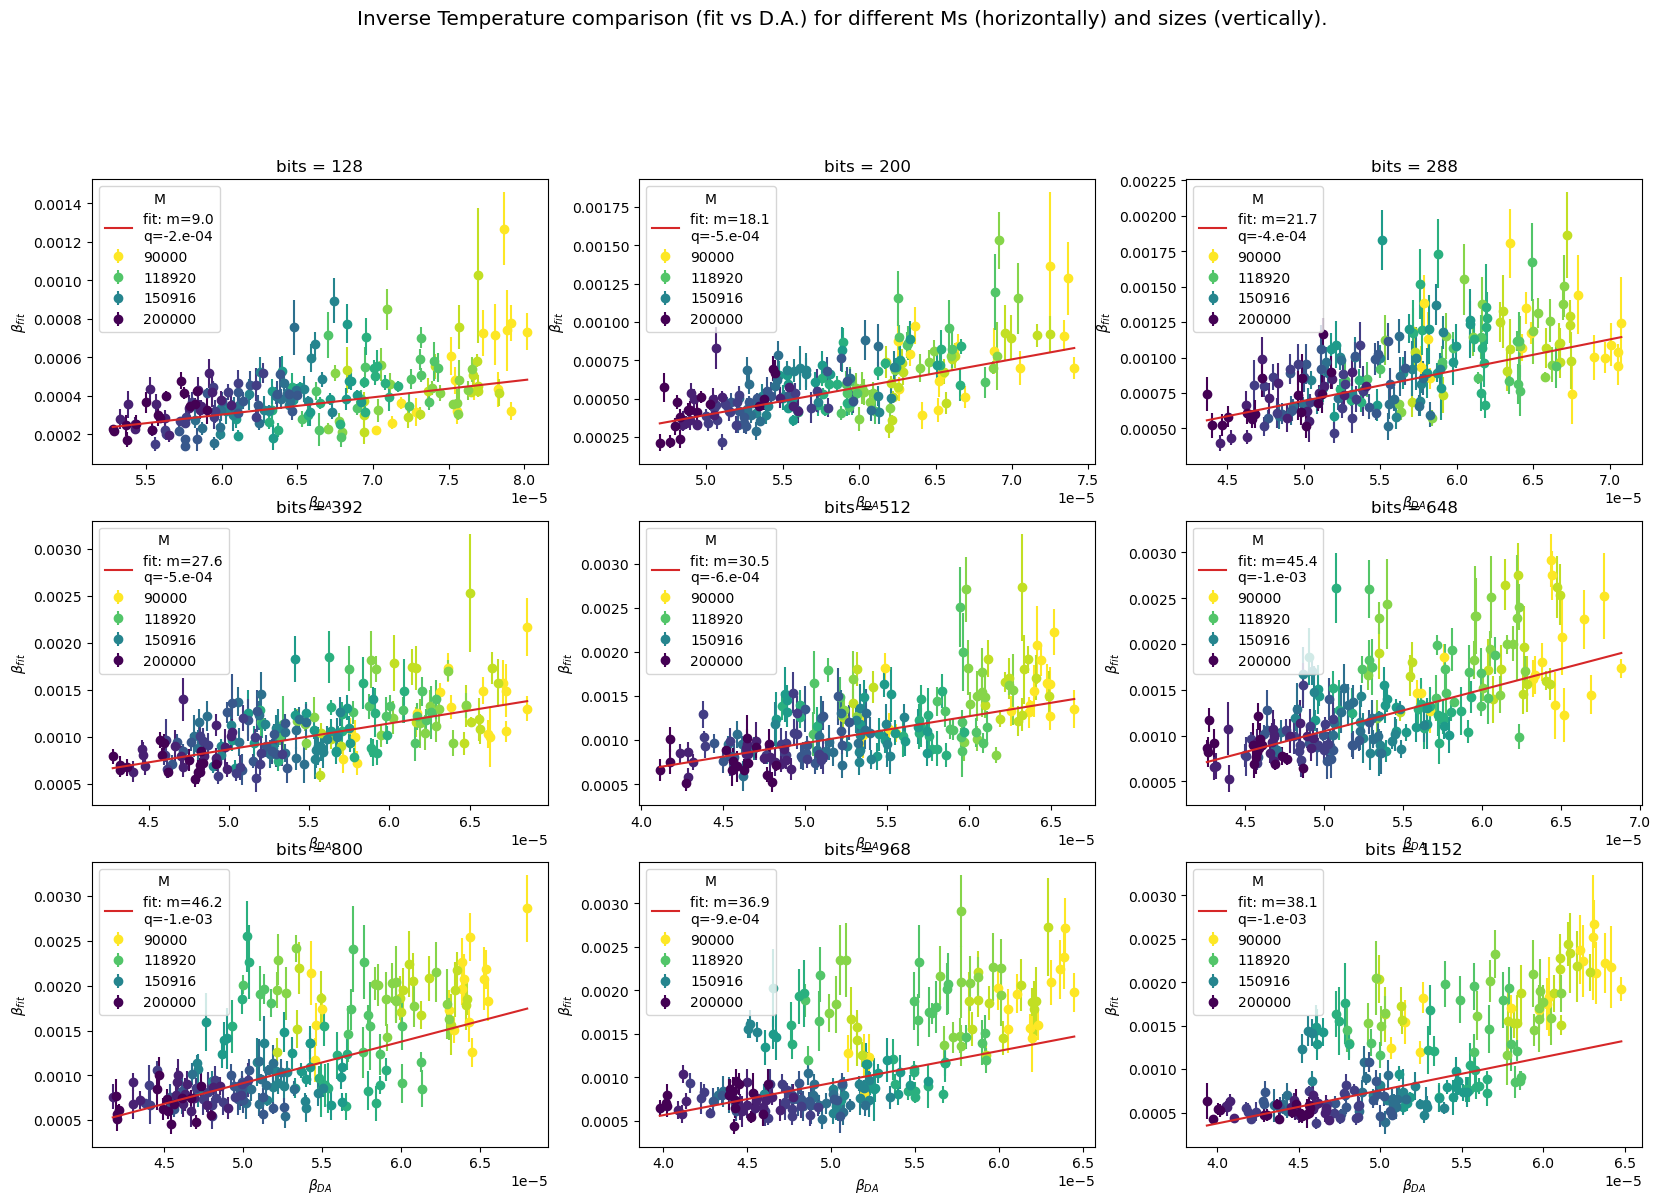

In [9]:
### Beta_fit and Beta_DA correlation (for multiple Ms)

def get_beta_fit(data_NM_inst_seed, which, bins, fit_lim):
    '''
    Given energies at given N, M, instance (vseed) and DA initialization (dseed), fit MB at given dimension and return fitted temperature and associated error
    '''
    # get data ready
    ener = np.reshape(data_NM_inst_seed, newshape = (runs, 2))
    if which == 'valid':
        valids = ener[:, 1] == 0
        y_ener = ener[valids, 0]
    elif which == 'all':
        y_ener = ener[:, 0] + ener[:, 1]
    else:
        raise ValueError("energy histogram to plot not understood")
    
    # get histogram data
    counts, x_bins = np.histogram(y_ener, bins = bins, range = (0, 30_000))
    density = counts / counts.sum() # normalize to get a probability
    x_pos = (x_bins[1:] + x_bins[:-1])/2
    bin_width = x_bins[1]-x_bins[0]
    mask = density > 0 # filter out empty bins
    density, x_pos = density[mask], x_pos[mask]

    # FIT for distribution
    start, _ = nearest_to(x_pos, fit_lim[0])
    end, _ = nearest_to(x_pos, fit_lim[1])
    f = lambda x, D, beta : gamma.pdf(x, (D+1)/2, loc = 0, scale = 1/beta) * bin_width
    coef, coef_var = sp.optimize.curve_fit(f, x_pos[start:end+1], density[start:end+1], p0 = [5, 1e-3])
    return coef[1], np.sqrt(coef_var[1,1])


def restrict_labels(len_tot, len_partial):
    # choose which values to have labels
    label_restricted = []
    for k in range(len_partial - 1):
        label_restricted.append( len_tot//len_partial * k )
    label_restricted.append(len_tot-1)
    return label_restricted

def plot_temps_aggregate(data_N, plot_Ms, N_idx, which, bins, plot_code, fit_lim, fig):
    '''
    Plot fitted vs DA temperatures for different instances (vseed), DA initializations (dseed) AND M values. Points are colored differently referring to different Ms.
    '''
    ax = fig.add_subplot(*plot_code)
    colormap = plt.cm.viridis.reversed()
    discr_colors = ListedColormap(colormap(np.linspace(0, 1, len(plot_Ms))))
    
    # cherrypick labels
    label_Ms_idx = restrict_labels(len(plot_Ms), len_partial = 4)
    beta_fit, beta_fit_err, beta_DA = np.ndarray((len(plot_Ms), n_vseeds, n_dseeds)), np.ndarray((len(plot_Ms), n_vseeds, n_dseeds)), np.ndarray((len(plot_Ms), n_vseeds, n_dseeds))
    # get betas and plot, for all M, vseed and dseed
    for plot_idx, M in enumerate(plot_Ms):
        M_idx, M = nearest_to(Ms, M)
        for idx_inst in range(n_vseeds):
            for j in range(n_dseeds):
                # get betas
                beta_fit[plot_idx, idx_inst, j], beta_fit_err[plot_idx, idx_inst, j] = get_beta_fit(data_N[M_idx, idx_inst, j], which, bins, fit_lim)
        beta_DA[plot_idx] = 1/data_temp[N_idx, M_idx, :, :, 1]
        # plot (label only 4 in total)
        if plot_idx in label_Ms_idx:
            ax.errorbar(beta_DA[plot_idx].flatten(), beta_fit[plot_idx].flatten(), yerr = beta_fit_err[plot_idx].flatten(), fmt='o', color = discr_colors.colors[plot_idx], label = str(M))
        else:
            ax.errorbar(beta_DA[plot_idx].flatten(), beta_fit[plot_idx].flatten(), yerr = beta_fit_err[plot_idx].flatten(), fmt='o', color = discr_colors.colors[plot_idx])

    # linear fit
    func = lambda x, m, q: m*x + q
    coef, coef_var = sp.optimize.curve_fit(func, beta_DA.flatten(), beta_fit.flatten(), sigma = beta_fit_err.flatten(), absolute_sigma = True)
    Xs = np.linspace(np.min(beta_DA), np.max(beta_DA), 100)
    plt.plot(Xs, func(Xs, *coef), color = 'C3', zorder = 4, label = f"fit: m={np.round(coef[0], 1)}"+# +- {np.round(np.sqrt(coef_var[0,0]), 1)} " + 
            f"\nq={np.format_float_scientific(coef[1], 0)}") #+- {np.format_float_scientific(np.sqrt(coef_var[1,1]), 0)}")

    ax.set_xlabel(r"$\beta_{DA}$")
    ax.set_ylabel( r"$\beta_{fit}$")
    #ax.set_xscale("log")
    ax.legend(fontsize = 10, loc='best', title = "M")
    plt.title(f"bits = {Ns[N_idx] * Ps[N_idx]}")
    return



which = 'all'
plot_Ms = np.arange(90_000, 201_000, 10_000)
#plot_Ms = np.arange(1.4*10**5, 201_000, 10_000)
plot_Ns_idxs = [2, 3, 4, 5, 6, 7, 8, 9, 10]
bins = "auto"
fit_lim = [0, 20000]

fig = plt.figure(figsize=(20, 17))
fig.suptitle(f"Inverse Temperature comparison (fit vs D.A.) for different Ms (horizontally) and sizes (vertically).", fontsize="x-large")
for idx, N_idx in enumerate(plot_Ns_idxs):
    plot_code = (len(plot_Ns_idxs)//3 + 1, 3, idx + 1)
    plot_temps_aggregate(data[N_idx], plot_Ms, N_idx, which, bins, plot_code, fit_lim, fig)
plt.show()

## Random Sampling

#### Guess:

Suppose a QUBO instance has an "a priori sampling distribution" (spectral density?) which is Max-Boltz. (e.g. distribution of random uniformly sampling) $p_{0}(E_x) \sim E^{\frac{D-1}{2}} e^{-\beta^* E_x}$.

Sampling solutions from the QUBO through an annealing procedure would improve the sampling distribution by a Gibbs factor $p_{G}(E_x) \sim e^{-\beta_{DA} E_x}$.

The final sampling distribution would thus be a Max-Boltz. distribution with shifted temperature $\beta =\beta_{fit} = \beta^* + \beta_{DA}$:
\begin{align}
p(E_x) &\sim p_{0}(E_x) \times p_{G}(E_x) = \text{MB}(D, \beta^*; E_x) \times  \text{Gibbs}(\beta_{DA}; E_x) \propto E_x^{\frac{D-1}{2}} e^{-\beta^* E_x} \times e^{-\beta_{DA} E_x} \\
&\sim E_x^{\frac{D-1}{2}} e^{-(\beta^* + \beta_{DA}) E_x} = \text{MB}(D, \beta^* + \beta_{DA}; E_x)
\end{align}

$\beta$ is the one we finally fit from experimental data.
Expanding the Hamiltonians $H = H_o + M H_p$:


$$
H_o = P\alpha^2 + \sum_{i,p} (n_i^2 - 2\alpha n_i) x_{ip} + \sum_{p, i \ne i^{'}} n_i n_{i^{'}} x_{ip} x_{i^{'}p}
$$
where $\alpha = \sum_i n_i/P$.

$$
H_p = N - \sum_{i,p} x_{ip} + \sum_{i, p \ne p^{'}} x_{ip} x_{ip^{'}}
$$

In [ ]:
### Parameters Estimation (MoM theoretical and empirical, MaxLikelihood-like)

def params_MoM_theor(Q, constant):
    '''Given the QUBO formulation, with quadratic part Q and constant, returns Gamma parameters D and beta of the spectral density, from theoretical evaluations of first 2 moments (see MethodofMoments)on an Rademacher distribution'''
    assert np.sum(Q - Q.T) < 1e-8 # symmetry check

    Wi = np.sum(Q, axis = 0)
    trace = np.trace(Q)
    sum = np.sum(Q)
    sum_squares = np.sum( np.power(Q, 2) )

    D = 0.5 * (sum + trace + 4*constant)**2 / ( np.sum(np.power(Wi, 2)) + .5*sum_squares ) - 1
    beta = (sum + trace + 4*constant) / ( np.sum(np.power(Wi, 2)) + .5*sum_squares )
    return D, beta

def params_MoM_Hpen_NPP(N, P, M):
    ''' theoretical MoM (like params_MoM_theor function) applied specifically to H_pen of the NPP problem'''
    mean = N/4*(P**2 - 3*P + 4) *M
    var = N*P/8*( 2*(P-2)**2 + P ) *M**2
    D = 2*mean**2/var -1
    beta = mean/var
    return D, beta

def params_MoM_empir(Es):
    '''Method of Moments estimation of parameters, based on empirical samples rather than objective quadratic matrix (for which params_MoM_theor function is implemented)'''
    mu = np.mean(Es)
    sigma_sq = np.var(Es, ddof = 1) # ddof = 1 is to get sample variance (divided by n-1) rather than population variance (divided by n)
    D = 2*mu**2/sigma_sq - 1
    beta = mu/sigma_sq
    return D, beta

def params_Likelihood(Es): # for the origin of the formulas, check doi.org/10.1080/00031305.2018.1513376
    Es = Es.flatten()
    n = len(Es)
    Es = Es[Es != 0]
    mean_x = np.mean(Es)
    mean_log = np.mean(np.log(Es))
    mean_xlog = np.mean(Es*np.log(Es))
    theta = mean_xlog - mean_x*mean_log
    k = mean_x / theta

    beta_unbais = (n-1)/n/theta
    k_unbias = k - (3*k - 2*k/(1 + k)/3 - 4*k/(1+k)**2/5)/n
    D_unbias = 2*k_unbias - 1
    return D_unbias, beta_unbais


In [9]:
### Random Sampling functions (same Fujitsu-generated instance) for NPP problems

import random

def build_numbs_set(N, P, seed):
    random.seed(seed)
    numbs = np.array([int(1000*random.uniform(0.0, 1.0)) for _ in range(N)])
    total = sum(numbs)
    if numbs[-1] - (total % P) > 1:
        numbs[-1] -= (total % P)
    else:
        numbs[-1] += (P - (total % P))
    total = sum(numbs)
    return numbs

def idx_onehot(i, p, P):
    return i*P + p

def build_obj(numbs, N, P):
    H = np.zeros((N*P, N*P))
    alpha = np.sum(numbs)/P

    for p in range(P):
        for i in range(N):
            H[idx_onehot(i, p, P), idx_onehot(i, p, P)] = numbs[i]**2 - 2*alpha*numbs[i]
            for i_prime in range(N):
                if i_prime == i:
                    continue
                H[idx_onehot(i, p, P), idx_onehot(i_prime, p, P)] = numbs[i] * numbs[i_prime]
    const = P*alpha**2
    H = symmetrize(H)
    return H, const

def build_pen(N, P):
    H = np.zeros((N*P, N*P))
    for p in range(P):
        for i in range(N):
            H[idx_onehot(i, p, P), idx_onehot(i, p, P)] = -1
            for p_prime in range(P):
                if p_prime == p:
                    continue
                H[idx_onehot(i, p, P), idx_onehot(i, p_prime, P)] = 1
    const = N
    H = symmetrize(H)
    return H, const

def symmetrize(Q):
    return (Q + Q.T)/2

def evaluate_energy(solution, Q, const):
    return const + np.dot(solution, np.dot(Q, solution))

def sample_sol(N, P):
    return np.random.randint(0, 2, size = N*P)

def get_QUBO(N, P, M, seed, penalization = True, objective = True):
    # build a NPP QUBO with N integers, P partitions, M penalty factor, for problem identified with seed
    Q, const = np.zeros((N*P, N*P)), 0
    if objective:
        numbs = build_numbs_set(N, P, seed)
        Ho, const_o = build_obj(numbs, N, P)
        Q += Ho
        const += const_o
    if penalization:
        Hp, const_p = build_pen(N, P)
        Q += M*Hp
        const += M*const_p
    return Q, const

def RandomSampler(Q, const, N, P, n_sample):
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        x = sample_sol(N, P)
        Es[j] = evaluate_energy(x, Q, const)
    return Es

def RandomSampler_Feasible(N, P, seed, n_sample):
    numbs = build_numbs_set(N, P, seed)
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        assign = np.random.randint(P, size = N)
        subset_sums = [ np.sum(numbs[assign == p]) for p in range(P)]
        Es[j] = P*np.var(subset_sums) # NB the objective energy can be reformulated as the variance of the subsets' sums (scaled by P)
    return Es




N_idx = 2
N, P = Ns[N_idx], Ps[N_idx]
seed = 43
M = 0*1e6
#M_idx, M = nearest_to(Ms, M)
n_sample = 100_000

Q, const = get_QUBO(N, P, M, seed, objective=True, penalization=True)
Es = RandomSampler(Q, const, N, P, n_sample)
# Es = RandomSampler_Feasible(N, P, seed, n_sample)

mean_th = (np.sum(Q) + np.trace(Q))/4 + const
mean_sq_th = np.sum( np.power( np.sum(Q, axis = 1) ,2) )/4 + np.sum( np.power(Q,2) )/8 + (const + ( np.sum(Q) + np.trace(Q) )/4)**2
var_th = np.sum(np.power( np.sum(Q, axis = 0) , 2))/4 + (np.sum(np.power(Q, 2)))/8
mean_emp = np.mean(Es)
mean_sq_emp = np.mean(np.power(Es, 2))
var_emp = np.var(Es, ddof = 1)
print(f"Mean\nexper: {mean_emp}\ttheor: {mean_th}\tRel error: {(mean_emp - mean_th)/mean_emp*100}%\tAbs error: {np.format_float_scientific((mean_emp - mean_th), 3)}")
print(f"Meanmean_sq\nexper: {mean_emp**2}\ttheor: {mean_th**2}\tRel error: {(mean_emp**2 - mean_th**2)/mean_emp**2*100}%\tAbs error: {np.format_float_scientific((mean_emp**2 - mean_th**2), 3)}")
print(f"Mean_sq\nexper: {np.format_float_scientific(mean_sq_emp, 2)}\ttheor: {np.format_float_scientific(mean_sq_th, 2)}\tRel error: {(mean_sq_emp - mean_sq_th)/mean_sq_emp*100}%\tAbs error: {np.format_float_scientific((mean_sq_emp - mean_sq_th), 3)}")
print(f"Variance\nexper: {np.format_float_scientific(var_emp, 2)}\t\ttheor: {np.format_float_scientific(var_th, 2)}\t\tRel error: {(var_emp - var_th)/var_emp*100}%\tAbs error: {np.format_float_scientific((var_emp - var_th), 3)}")

print(f"N = {N}, P = {P}")

Mean
exper: 69845914.97002	theor: 69835322.0	Rel error: 0.015166198373294979%	Abs error: 1.059e+04
Meanmean_sq
exper: 4878451837999263.0	theor: 4876972198843684.0	Rel error: 0.03033009661085074%	Abs error: 1.48e+12
Mean_sq
exper: 5.51e+15	theor: 5.75e+15	Rel error: -4.416231681766473%	Abs error: -2.434e+14
Variance
exper: 6.33e+14		theor: 8.78e+14		Rel error: -38.69055335475975%	Abs error: -2.449e+14
N = 32, P = 4


Dim_theo: 10.11			beta_theo: 7.956e-08
Dim_emp: 14.42			beta_emp: 1.104e-07
Dim_ML: 13.86			beta_ML: 1.06e-07
Dim_fit: 13.89 +- 0.1 		beta_fit: 1.047e-07 +- 7.7e-10

Error fit - theo:
		D_err: 27.18%		beta_err: 24.03%
Error fit - emp:
		D_err: -3.82%		beta_err: -5.38%


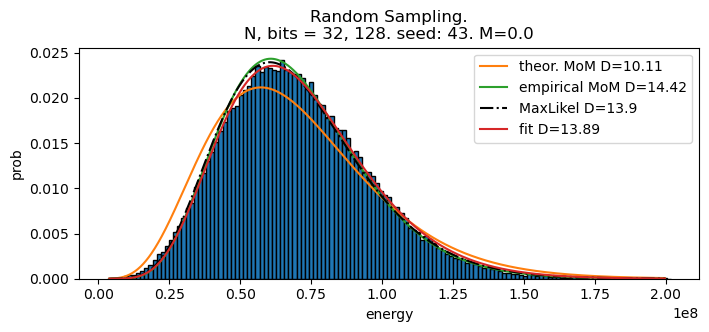

In [10]:
# beta_gibbs = 1e-3



### Random sampling
bins = "auto"
#bins = 200
#fit_lim = [.4*1e6, 1*1e7]
counts, x_bins = np.histogram(Es, bins = bins)
density = counts / counts.sum() # normalize to get a probability
x_pos = (x_bins[1:] + x_bins[:-1])/2
bin_width = x_bins[1]-x_bins[0]
mask = density > 0 # filter out empty bins
density, x_pos = density[mask], x_pos[mask]
# plot
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.bar(x_pos, density, width = bin_width, edgecolor='k', linewidth=1)
ax.set_ylabel("prob")
ax.set_xlabel("energy")
plt.title(f"Random Sampling.\nN, bits = {N}, {N*P}. seed: {seed}. M={M}")
#fit
# start, _ = nearest_to(x_pos, fit_lim[0])
# end, _ = nearest_to(x_pos, fit_lim[1])
start, end = 0, -2
XS = np.linspace(x_pos[start], x_pos[end], 1000)
#XS = np.append([0], XS)
f = lambda x, D, beta : gamma.pdf(x, (D+1)/2, loc = 0, scale = 1/beta) * bin_width
coef_theo = params_MoM_theor(Q, const) # parameters from theoretical MoM (moments based on Q matrix)
ax.plot(XS, f(XS, *coef_theo), color = "C1", label = f"theor. MoM D={np.round(coef_theo[0], 2)}")
print(f"Dim_theo: {np.round(coef_theo[0], 2)}\t\t\tbeta_theo: {np.format_float_scientific(coef_theo[1], 3)}")

coef_empir = params_MoM_empir(Es) # parameters from empirical MoM (moments based on distribution moments)
ax.plot(XS, f(XS, *coef_empir), color = "C2", label = f"empirical MoM D={np.round(coef_empir[0], 2)}")
print(f"Dim_emp: {np.round(coef_empir[0], 2)}\t\t\tbeta_emp: {np.format_float_scientific(coef_empir[1], 3)}")

coef_ML = params_Likelihood(Es)
print(f"Dim_ML: {np.round(coef_ML[0], 2)}\t\t\tbeta_ML: {np.format_float_scientific(coef_ML[1], 2)}")
ax.plot(XS, f(XS, *coef_ML), "-.", color = "k", label = f"MaxLikel D={np.round(coef_ML[0], 1)}")

coef_RS, coef_var = sp.optimize.curve_fit(f, x_pos[start:end+1], density[start:end+1], p0 = coef_theo)
coef_std = np.sqrt(np.diag(coef_var))
ax.plot(XS, f(XS, *coef_RS), color = "C3", label = f"fit D={np.round(coef_RS[0], 2)}")
print(f"Dim_fit: {np.round(coef_RS[0], 2)} +- {np.round(coef_std[0], 2)} \t\tbeta_fit: {np.format_float_scientific(coef_RS[1], 3)} +- {np.format_float_scientific(coef_std[1], 1)}")


print(f"\nError fit - theo:\n\t\tD_err: {np.round((coef_RS[0]-coef_theo[0])/coef_RS[0]*100, 2)}%\t\tbeta_err: {np.round((coef_RS[1]-coef_theo[1])/coef_RS[1]*100, 2)}%")
print(f"Error fit - emp:\n\t\tD_err: {np.round((coef_RS[0]-coef_empir[0])/coef_RS[0]*100, 2)}%\t\tbeta_err: {np.round((coef_RS[1]-coef_empir[1])/coef_RS[1]*100, 2)}%")

ax.legend(fontsize = 10, loc='best')
plt.show()



## M-method ALGORITHM application

In [27]:
### Test M method (create problem, apply technique, simulate Gibbs sampling and plot)
import sys
sys.path.append('../../')
from myalgo import M_method_opt, M_method_feas



# 1. set problem 
problem_type = "NPP"
N_idx = 12
N, P = Ns[N_idx], Ps[N_idx]
size = (N, P)
print(f"NPP problem, size:  N = {N}, P = {P}")
vseed = 45
vseed_idx = 3

# # 2. set parameters: temperature, min_probabilty, max_energy and vioaltion_peaks
beta_sampling = 1 / np.mean(data_temp[N_idx, :, vseed_idx, :, 1])
min_pfeas = 0.5 # eta
E_f = 1e7
peak_max = 4
E_LB = 0

# 3. apply method to find penalty M
#print("\nApplying method where P_f bound is tighter (almost integration-like)")
M, eta_guaranteed = M_method_opt(size, problem_type, vseed, "seed", beta_sampling, peak_max, min_pfeas, E_f, E_LB)

NPP problem, size:  N = 112, P = 14


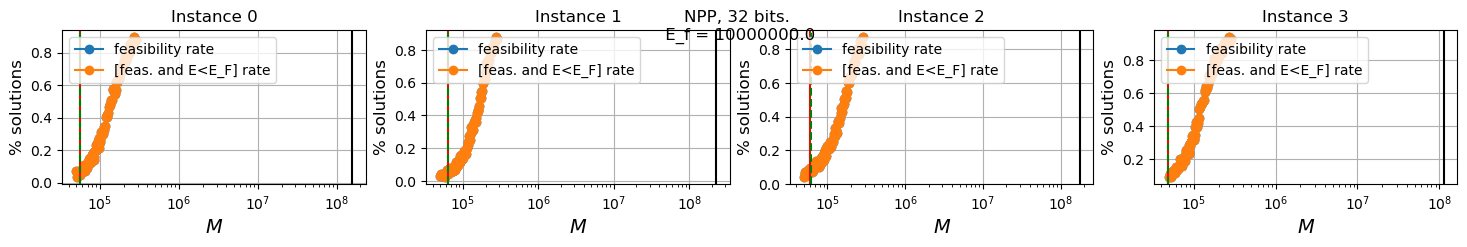

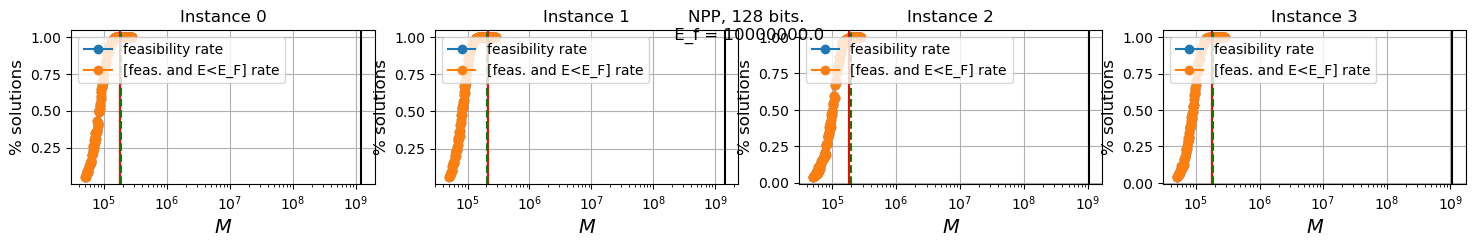

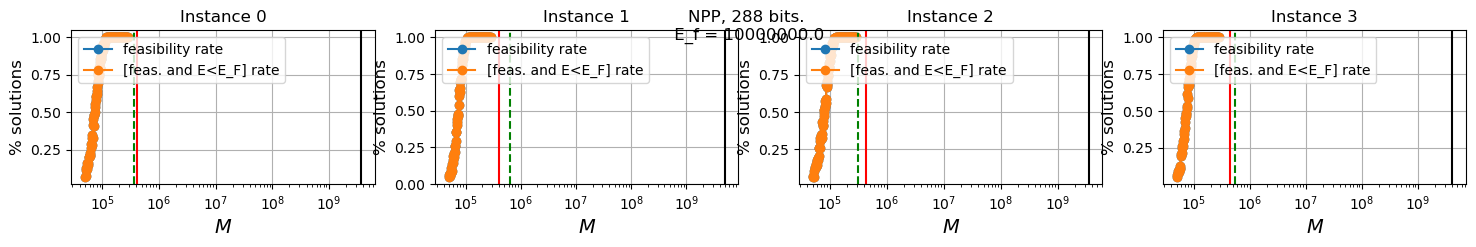

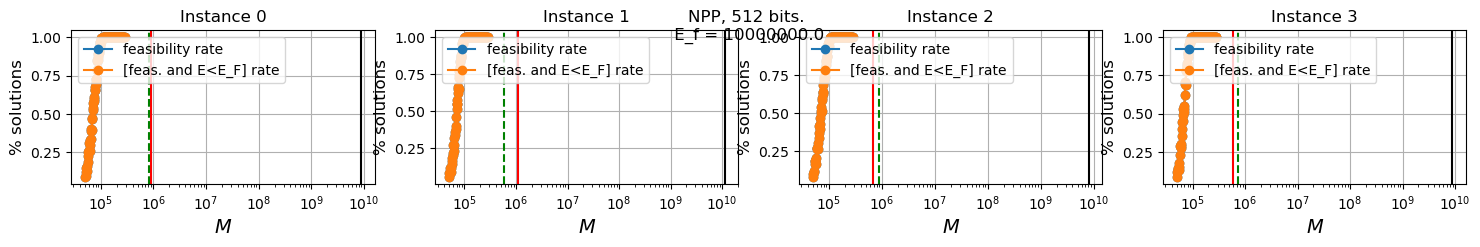

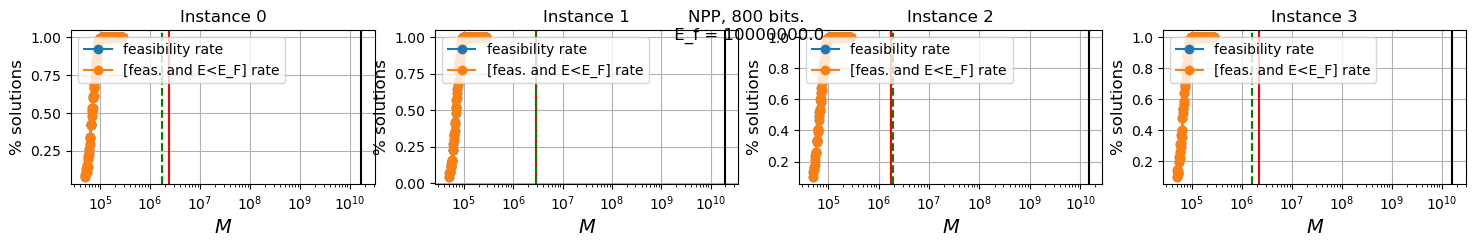

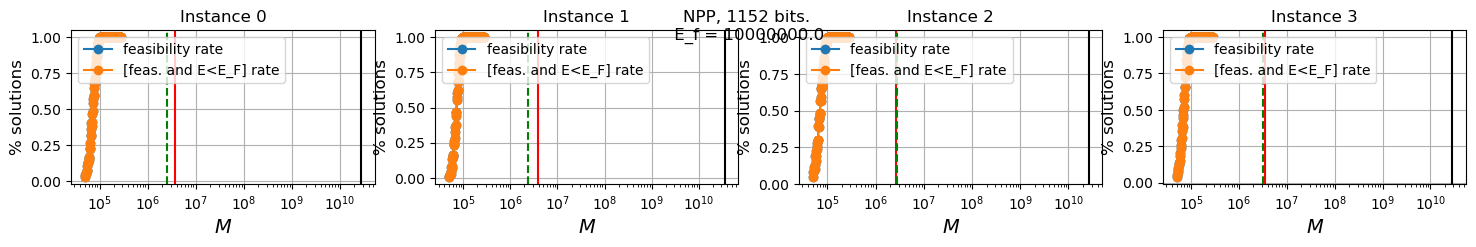

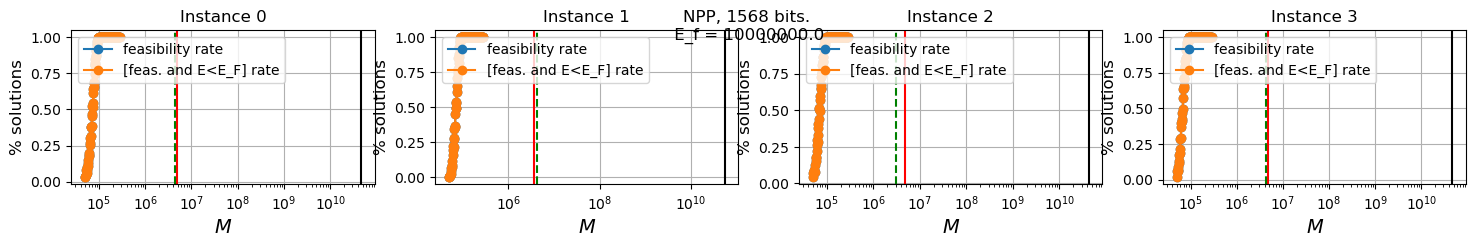

In [ ]:
### Test method on multiple instances, for all sizes, and compare with empirical cumulative distribution


problem_type = "NPP"
E_f = 1e7  # decrease to 1e6 or 3e6 and implement, for higher sizes, doubling of E_f whenever eta_max = 0
min_pfeas = 0.5 # eta
E_LB = 0
peak_max = 4

for N_idx in np.arange(0, 13, 2):
    N, P = Ns[N_idx], Ps[N_idx]
    size = (N, P)
    n_samples = runs * n_dseeds
    feas_prob, opt_prob = np.ndarray((n_vseeds, len(Ms))), np.ndarray((n_vseeds, len(Ms)))

    fig = plt.figure(figsize=(18, 2))
    fig.suptitle(f"NPP, {Ns[N_idx]*Ps[N_idx]} bits.\n E_f = {E_f}")
    for inst_idx in range(n_vseeds):
        # compute estimated M
        vseed = seeds[inst_idx]

        # M_trans_approx = 8e4
        # M_idx, _ = nearest_to(Ms, M_trans_approx)
        # beta_sampling_single = 1 / np.mean(data_temp[N_idx, M_idx, inst_idx, :, 1])

        beta_sampling_mean = 1 / np.mean(data_temp[N_idx, :, inst_idx, :, 1])        
        M_estimated, eta_guaranteed = M_method_opt(size, problem_type, int(vseed), "seed", beta_sampling_mean, peak_max, min_pfeas, E_f, E_LB)
        M_estimated_feas, eta_guaranteed = M_method_feas(size, problem_type, int(vseed), "seed", beta_sampling_mean, peak_max, min_pfeas, E_LB)
        #M_estimated_single, eta_guaranteed = M_method_opt(size, problem_type, int(vseed), "seed", beta_sampling_single, peak_max, min_pfeas, E_f, E_LB)

        # L1 norm estimate of M
        Q_obj, const_obj = get_QUBO(N, P, 0, int(vseed), penalization = False)
        M_L1 = L1_norm(Q_obj, const_obj)
        M_L1_hot = L1_norm_hot(Q_obj, const_obj, N*P, 1/beta_sampling_mean, max_prob_inf = min_pfeas)


        # calculate empirical probs
        for M_idx in range(len(Ms)):
            feas_prob[inst_idx, M_idx] = np.sum( data[N_idx, M_idx, inst_idx, :, :, 1] == 0) / n_samples
            opt_prob[inst_idx, M_idx] =  np.sum( np.logical_and(data[N_idx, M_idx, inst_idx, :, :, 1] == 0, data[N_idx, M_idx, inst_idx, :, :, 0] <= E_f) )  / n_samples

        # plot
        ax = fig.add_subplot(1, 4, inst_idx+1)
        ax.set_title(f"Instance {inst_idx}")                   
        ax.plot(Ms, feas_prob[inst_idx],"-o", color = "C0", label = 'feasibility rate')
        ax.plot(Ms, opt_prob[inst_idx],"-o", color = "C1", label = '[feas. and E<E_F] rate')
        ax.set_ylabel("% solutions", fontsize=12)
        ax.set_xlabel(r"$M$",fontsize=14)
        ax.legend(fontsize = 10, loc='upper left')
        ax.axvline(M_estimated, color = "r", label = "M_{opt}")
        ax.axvline(M_estimated_feas, color = "g", linestyle = "--", label = "M_{feas}")
        #ax.axvline(M_L1, color = "y")
        ax.axvline(M_L1_hot, color = "k", label = "M_{l1}")
        #ax.axvline(M_estimated_single, color = "k")
        plt.xscale('log')
        #plt.yscale('log')
        plt.grid()
    plt.show()

        

In [29]:
# ratio M / M_transition   ---   FEASIBILITY strategy


Ns_idx_ratios = np.arange(0, 13, 2)
ratios_M_feas, ratios_M_l1 = np.ndarray((len(Ns_idx_ratios), n_vseeds)), np.ndarray((len(Ns_idx_ratios), n_vseeds))

problem_type = "NPP"
min_pfeas = 0.5 # eta
E_LB = 0
peak_max = 4

for N_idx_short, N_idx in enumerate(tqdm.tqdm(Ns_idx_ratios)):
    N, P = Ns[N_idx], Ps[N_idx]
    size = (N, P)
    n_samples = runs * n_dseeds
    opt_prob = np.zeros((len(Ms)))

    
    for inst_idx in range(n_vseeds):
        # compute transition M
        for M_idx in range(len(Ms)):
            #feas_prob[inst_idx, M_idx] = np.sum( data[N_idx, M_idx, inst_idx, :, :, 1] == 0) / n_samples
            opt_prob[M_idx] =  np.sum( np.logical_and(data[N_idx, M_idx, inst_idx, :, :, 1] == 0, data[N_idx, M_idx, inst_idx, :, :, 0] <= E_f) )  / n_samples
        M_idx_trans, opt_prob_trans = nearest_to(opt_prob, .5)
        M_trans = Ms[M_idx_trans]

        
        # compute estimated M
        vseed = seeds[inst_idx]
        beta_mean = 1 / np.mean(data_temp[N_idx, :, inst_idx, :, 1])
        M, eta_guaranteed = M_method_feas(size, problem_type, int(vseed), "seed", beta_mean, peak_max, min_pfeas, E_LB)
        # beta_single = 1 / np.mean(data_temp[N_idx, M_idx_trans, inst_idx, :, 1])
        # M_estimated_single, eta_guaranteed = M_method_opt(size, problem_type, int(vseed), betag_single, peak_max, min_pfeas, E_f, E_LB)
    
        # compute l1 M
        Q_obj, const_obj = get_QUBO(N, P, 0, int(vseed), penalization = False)
        M_L1_hot = L1_norm_hot(Q_obj, const_obj, N*P, 1/beta_mean, max_prob_inf = min_pfeas)
        
        ratios_M_feas[N_idx_short, inst_idx] = M / M_trans
        ratios_M_l1[N_idx_short, inst_idx] = M_L1_hot / M_trans

100%|██████████| 7/7 [00:15<00:00,  2.18s/it]


X-Y for our-ratios [  32  128  288  512  800 1152 1568] [ 0.39236133  2.14692328  5.63870134 13.44321408 20.44231434 41.96230203
 65.77496125]
X-Y for l1-ratios [  32  128  288  512  800 1152 1568] [  1125.13873817  13674.90026428  53888.17110512 134177.28083652
 247078.61272002 415649.14271532 674688.2881081 ]


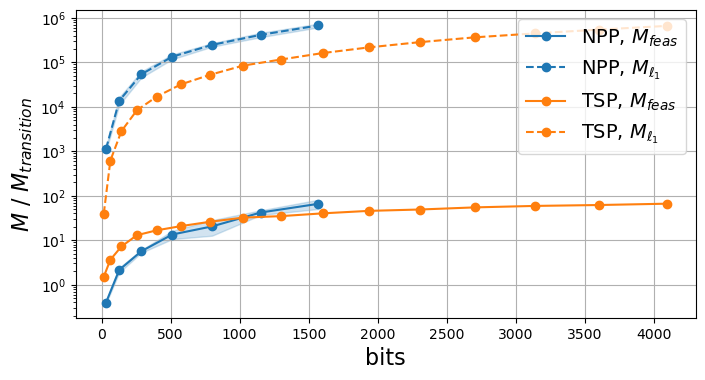

In [ ]:
#### plot ratio scaling using feasibility strategy

### TSP data
bits_axes_TSP = [  16,   64,  144,  256,  400,  576,  784, 1024, 1296, 1600, 1936, 2304, 2704, 3136, 3600, 4096] 
ratios_M_TSP_feas = [ 1.50190337,  3.64026986,  7.23360665, 12.98257108, 16.71036823, 20.78021365, 25.96462226, 32.23091958, 34.76449956, 40.18887265, 45.72468109, 49.05369118, 54.78309467, 59.07456242, 61.89804037, 66.34150468]
ratios_M_TSP_l1 = [3.90750432e+01, 6.17822321e+02, 2.83989459e+03 ,8.35783237e+03, 1.70094757e+04, 3.20652673e+04, 5.23425864e+04 ,8.44376753e+04, 1.15543589e+05, 1.61617587e+05, 2.17243624e+05, 2.84864893e+05, 3.65847215e+05, 4.47762825e+05 ,5.45240023e+05 ,6.61679524e+05]
###

bits_axes = Ns[Ns_idx_ratios] * Ps[Ns_idx_ratios]
## print NPP (this) data if needed in TSP notebook
print("X-Y for our-ratios", bits_axes, np.mean(ratios_M_feas, axis = 1))
print("X-Y for l1-ratios", bits_axes, np.mean(ratios_M_l1, axis = 1))

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.set_ylabel(r"$M$ / $M_{transition}$", fontsize=16)
ax.set_xlabel("bits",fontsize=16)
# plot data               
ax.plot(bits_axes, np.mean(ratios_M_feas, axis = 1),"-o", color = "C0", label = r"NPP, $M_{feas}$")
ax.fill_between(bits_axes, np.mean(ratios_M_feas, axis = 1) - np.std(ratios_M_feas, axis = 1), np.mean(ratios_M_feas, axis = 1) + np.std(ratios_M_feas, axis = 1), color = "C0", alpha=.2)
ax.plot(bits_axes, np.mean(ratios_M_l1, axis = 1),"--o", color = "C0", label = r"NPP, $M_{\ell_1}$")
ax.fill_between(bits_axes, np.mean(ratios_M_l1, axis = 1) - np.std(ratios_M_l1, axis = 1), np.mean(ratios_M_l1, axis = 1) + np.std(ratios_M_l1, axis = 1), color = "C0", alpha=.2)
ax.plot(bits_axes_TSP, ratios_M_TSP_feas,"-o", color = "C1", label = r"TSP, $M_{feas}$")
ax.plot(bits_axes_TSP, ratios_M_TSP_l1,"--o", color = "C1", label = r"TSP, $M_{\ell_1}$")
ax.legend(fontsize = 14, loc='best')
ax.set_yscale('log')
plt.grid()

## Perfect Gibbs sampler test

In the next cells it is tested the hypothesis that the distribution of a perfect Gibbs sampler is a product of a Gibbs factor and the spectral distribution (substitutable by the Random Sampling one). Namely,
$$
p_{Gsampler}(E_x) = p_{RS}(E_x) \times p_{G}(E_x)
$$

In [20]:
#### Gibbs Sampling functions

def state_i(i, n):
    state_string = bin(i)[2:].zfill(n)
    return [int(b) for b in state_string]

def compute_Gibbs_probs(beta, Q, const, n):
    size, _ = np.shape(Q)
    assert size == n
    ener = np.array([ evaluate_energy(state_i(i, n), Q, const) for i in range(2**n)])
    probs = np.exp(-beta*ener)
    probs /= probs.sum()
    return probs, ener

def sample_Gibbs(probs, eners, n_samples):
    eners_sampled = np.random.choice(eners, p = probs, size = n_samples)
    return eners_sampled


def perf_GibbsSampler(beta, Q, const, n, n_G_samples):
    probs, ener = compute_Gibbs_probs(beta, Q, const, n)
    return sample_Gibbs(probs, ener, n_G_samples)

In [21]:
### Random Sampling functions (customizable instance)

import random

def build_numbs_set(N, P, seed):
    random.seed(seed)
    numbs = [int(1000*random.uniform(0.0, 1.0)) for _ in range(N)]
    total = sum(numbs)
    if numbs[-1] - (total % P) > 1:
        numbs[-1] -= (total % P)
    else:
        numbs[-1] += (P - (total % P))
    total = sum(numbs)
    return numbs

def idx_onehot(i, p, P):
    return i*P + p

def build_obj(numbs, N, P):
    H = np.zeros((N*P, N*P))
    alpha = np.sum(numbs)/P

    for p in range(P):
        for i in range(N):
            H[idx_onehot(i, p, P), idx_onehot(i, p, P)] = numbs[i]**2 - 2*alpha*numbs[i]
            for i_prime in range(N):
                if i_prime == i:
                    continue
                H[idx_onehot(i, p, P), idx_onehot(i_prime, p, P)] = numbs[i] * numbs[i_prime]
    const = P*alpha**2
    return H, const

def build_pen(N, P):
    H = np.zeros((N*P, N*P))
    for p in range(P):
        for i in range(N):
            H[idx_onehot(i, p, P), idx_onehot(i, p, P)] = -1
            for p_prime in range(P):
                if p_prime == p:
                    continue
                H[idx_onehot(i, p, P), idx_onehot(i, p_prime, P)] = 1
    const = N
    return H, const

def evaluate_energy(solution, Q, const):
    return const + np.dot(solution, np.dot(Q, solution))

def sample_sol(N, P):
    return np.random.randint(0, 2, size = N*P)

def get_QUBO(N, P, M, seed, objective = True, penalization=True):
    # build a NPP QUBO with N integers, P partitions, M penalty factor, for problem identified with seed
    Q, const = np.zeros((N*P, N*P)), 0
    if objective:
        numbs = build_numbs_set(N, P, seed)
        Ho, const_o = build_obj(numbs, N, P)
        Q += Ho
        const += const_o
    if penalization:
        Hp, const_p = build_pen(N, P)
        Q += M*Hp
        const += M*const_p
    return Q, const

def RandomSampler(Q, const, N, P, n_sample):
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        x = sample_sol(N, P)
        Es[j] = evaluate_energy(x, Q, const)
    return Es

def SpectralDistribution(Q, const, n_bits):
    ener = np.array([ evaluate_energy(state_i(i, n_bits), Q, const) for i in range(2**n_bits)])
    return ener

N = 8, P = 2
Dim: 2.05 +- 0.08 		beta: 3.7e-06 +- 1.6e-07


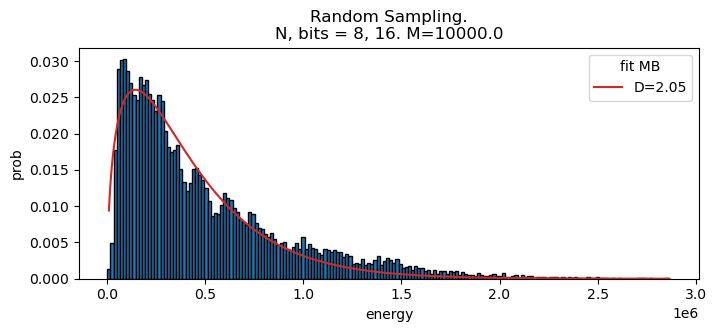

Dim_fit: 4.35 +- 0.21 		beta_fit: 2.4e-05 +- 1.1e-06


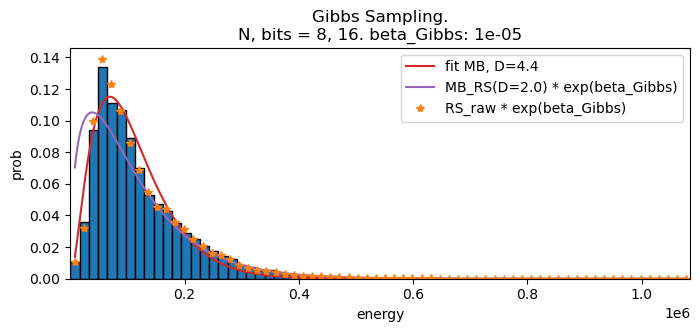

In [22]:
N, P = 8, 2
n_bits = N*P
print(f"N = {N}, P = {P}")
seed = 44
M = 1e4
#M_idx, M = nearest_to(Ms, M)

n_RS_sample = 100_000
n_GS_sample = n_RS_sample

n_qubos = 2
Es_GS, Es_RS, Es_SD = np.ndarray((n_qubos, n_RS_sample)), np.ndarray((n_qubos, n_RS_sample)), np.ndarray((n_qubos, 2**n_bits))
for i in range(n_qubos):
    Q, const = get_QUBO(N, P, M, seed + i)
    #Es_SD[i] = SpectralDistribution(Q, const, n_bits)
    # create RS data
    Es_RS[i] = RandomSampler(Q, const, N, P, n_RS_sample)
    # create Gibbs data
    beta_gibbs = 1e-5
    Es_GS[i] = perf_GibbsSampler(beta_gibbs, Q, const, n_bits, n_GS_sample)


### Random sampling
bins = "auto"
bins = 180
fit_lim = None
counts, x_bins = np.histogram(Es_RS.flatten(), bins = bins, )
density_RS = counts / counts.sum() # normalize to get a probability
x_pos_RS = (x_bins[1:] + x_bins[:-1])/2
bin_width_RS = x_bins[1]-x_bins[0]
mask = density_RS > 0 # filter out empty bins
density_RS, x_pos_RS = density_RS[mask], x_pos_RS[mask]
# plot
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.bar(x_pos_RS, density_RS, width = bin_width_RS, edgecolor='k', linewidth=1)
ax.set_ylabel("prob")
ax.set_xlabel("energy")
plt.title(f"Random Sampling.\nN, bits = {N}, {N*P}. M={M}")
# fit
if fit_lim == None:
    fit_lim = [np.min(x_pos_RS), np.max(x_pos_RS)]
start, _ = nearest_to(x_pos_RS, fit_lim[0])
end, _ = nearest_to(x_pos_RS, fit_lim[1])
XS = np.linspace(x_pos_RS[start], x_pos_RS[end], 1000)
f = lambda x, D, beta, norm : gamma.pdf(x, (D+1)/2, loc = 0, scale = 1/beta) * bin_width_RS * norm
coef_RS, coef_var = sp.optimize.curve_fit(f, x_pos_RS[start:end+1], density_RS[start:end+1], p0 = [5, 1e-7, 3])
coef_std = np.sqrt(np.diag(coef_var))
ax.plot(XS, f(XS, *coef_RS), color = "C3", label = f"D={np.round(coef_RS[0], 2)}")
corr = coef_var[0,1]/np.sqrt(coef_var[0,0]*coef_var[1,1])
print(f"Dim: {np.round(coef_RS[0], 2)} +- {np.round(coef_std[0], 2)} \t\tbeta: {np.format_float_scientific(coef_RS[1], 1)} +- {np.format_float_scientific(coef_std[1], 1)}")
#print(f"Correlation beta-D = {np.round(corr, 2)}")
ax.legend(fontsize = 10, loc='best', title = "fit MB")
plt.show()



### Gibbs sampling
#bins = "auto"
#bins = 80
bins = int(bins * (np.max(Es_GS) - np.min(Es_GS))/(np.max(Es_RS) - np.min(Es_RS))) # in order to have same bin sizes wrt RS plot 
fit_lim = None
counts, x_bins = np.histogram(Es_GS.flatten(), bins = bins)
density = counts / counts.sum() # normalize to get a probability
x_pos = (x_bins[1:] + x_bins[:-1])/2
bin_width_GS = x_bins[1]-x_bins[0]
mask = density > 0 # filter out empty bins
density, x_pos = density[mask], x_pos[mask]
# plot
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.bar(x_pos, density, width = bin_width_GS, edgecolor='k', linewidth=1)
ax.set_ylabel("prob")
ax.set_xlabel("energy")
plt.title(f"Gibbs Sampling.\nN, bits = {N}, {N*P}. beta_Gibbs: {beta_gibbs}")
#fit
if fit_lim == None:
    fit_lim = [np.min(x_pos), np.max(x_pos)]
start, _ = nearest_to(x_pos, fit_lim[0])
end, _ = nearest_to(x_pos, fit_lim[1])
XS = np.linspace(x_pos[start], x_pos[end], 1000)
f = lambda x, D, beta : gamma.pdf(x, (D+1)/2, loc = 0, scale = 1/beta) * bin_width_GS
coef_GS, coef_var = sp.optimize.curve_fit(f, x_pos[start:end+1], density[start:end+1], p0 = [5, 1e-7])
coef_std = np.sqrt(np.diag(coef_var))
ax.plot(XS, f(XS, *coef_GS), color = "C3", label = f"fit MB, D={np.round(coef_GS[0], 1)}")

f_product = lambda x : gamma.pdf(x, (coef_RS[0]+1)/2, loc = 0, scale = 1/(coef_RS[1] + beta_gibbs) ) * bin_width_GS
ax.plot(XS, f_product(XS), color = "C4", label = f"MB_RS(D={np.round(coef_RS[0], 1)}) * exp(beta_Gibbs)")

density_RS_shifted = density_RS * np.exp(-beta_gibbs*x_pos_RS)
density_RS_shifted /= np.sum(density_RS_shifted)
density_RS_shifted *= bin_width_GS/bin_width_RS
ax.plot(x_pos_RS, density_RS_shifted, "*", color = "C1", label = f"RS_raw * exp(beta_Gibbs)")

corr = coef_var[0,1]/np.sqrt(coef_var[0,0]*coef_var[1,1])
print(f"Dim_fit: {np.round(coef_GS[0], 2)} +- {np.round(coef_std[0], 2)} \t\tbeta_fit: {np.format_float_scientific(coef_GS[1], 1)} +- {np.format_float_scientific(coef_std[1], 1)}")
#print(f"Correlation beta-D = {np.round(corr, 2)}")
ax.legend(fontsize = 10, loc='best')
ax.set_xlim(np.min(Es_GS), np.max(Es_GS))
plt.show()


## Maxwell-Boltzmann in different dimensions


Maxwell - Boltzmann probability distribution function:

$p(E) = \mathcal{N}_{\beta, D} E^{(D-1)/2} e^{-\beta E}$
- $D=$ dimension
- $\beta=$ inverse temperature
- $\mathcal{N}_{\beta, D} =$ normalization factor

$
\mathcal{N}_{\beta, D} =
\begin{cases}
\frac{2^{D/2}}{(D-1)!!} \sqrt{ \frac{\beta^{D+1}}{\pi} } \; \textit{for } D \textit{ even} \\
\frac{\sqrt{\beta^{D+1}}}{(\frac{D-1}{2})!} \qquad \quad \textit{for } D \textit{ odd}
\end{cases}
$

Equivalent to a Gamma distribution $p(E) = \mathcal{N}_{\beta, D} E^{\alpha-1} e^{-\beta E}$
- $\alpha=$ shape factor (linked to dimension via $D = 2\alpha - 1 \iff \alpha = \frac{D+1}{2}$)
- $\beta=$ inverse temperature
- $\mathcal{N}_{\beta, D} = \frac{\beta^\alpha}{\Gamma(\alpha)}$ normalization factor

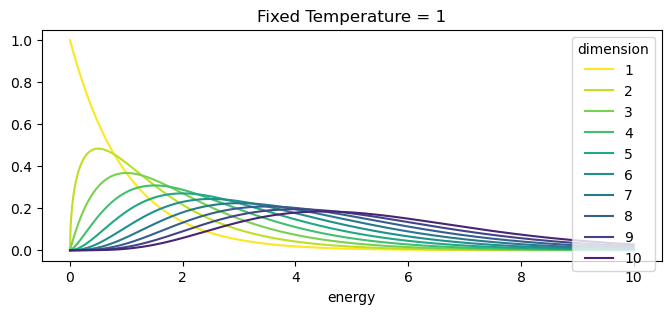

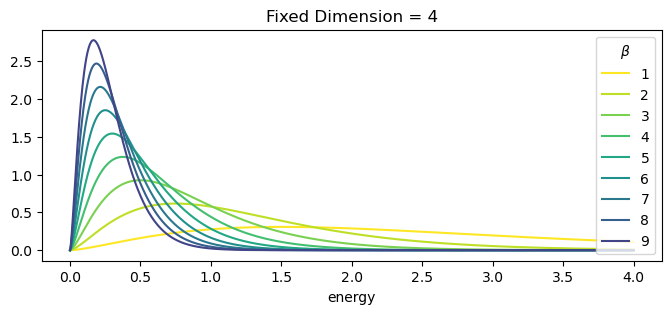

In [ ]:
### analytical plot of MB
### MB different Dimension (fixed T)
###

top_dim = 11
temperature = 1
colormap = plt.cm.viridis.reversed()
discr_colors = ListedColormap(colormap(np.linspace(0, 1, top_dim))) 

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
XS = np.linspace(0, 10, 1000)
for idx, j in enumerate(range(1, top_dim)):
    ax.plot(XS, gamma.pdf(XS, a = (j+1)/2, loc = 0, scale = 1/temperature), color = discr_colors.colors[idx], label = f"{j}")
#ax.set_ylabel("prob")
ax.set_xlabel("energy")
ax.set_title(f"Fixed Temperature = {temperature}")
ax.legend(fontsize = 10, loc='best', title = "dimension")
plt.show()



###
### MB different T (fixed Dimension)
###


top_temp = 10
colormap = plt.cm.viridis.reversed()
discr_colors = ListedColormap(colormap(np.linspace(0, 1, top_dim))) 

d = 4
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
XS = np.linspace(0, 4, 1000)
for idx, j in enumerate(range(1, top_temp)):
    ax.plot(XS, gamma.pdf(XS, a = (d+1)/2, loc = 0, scale = 1/j), color = discr_colors.colors[idx], label = f"{j}")
#ax.set_ylabel("prob")
ax.set_xlabel("energy")
ax.set_title(f"Fixed Dimension = {d}")
ax.legend(fontsize = 10, loc='best', title = r"$\beta$")
plt.show()

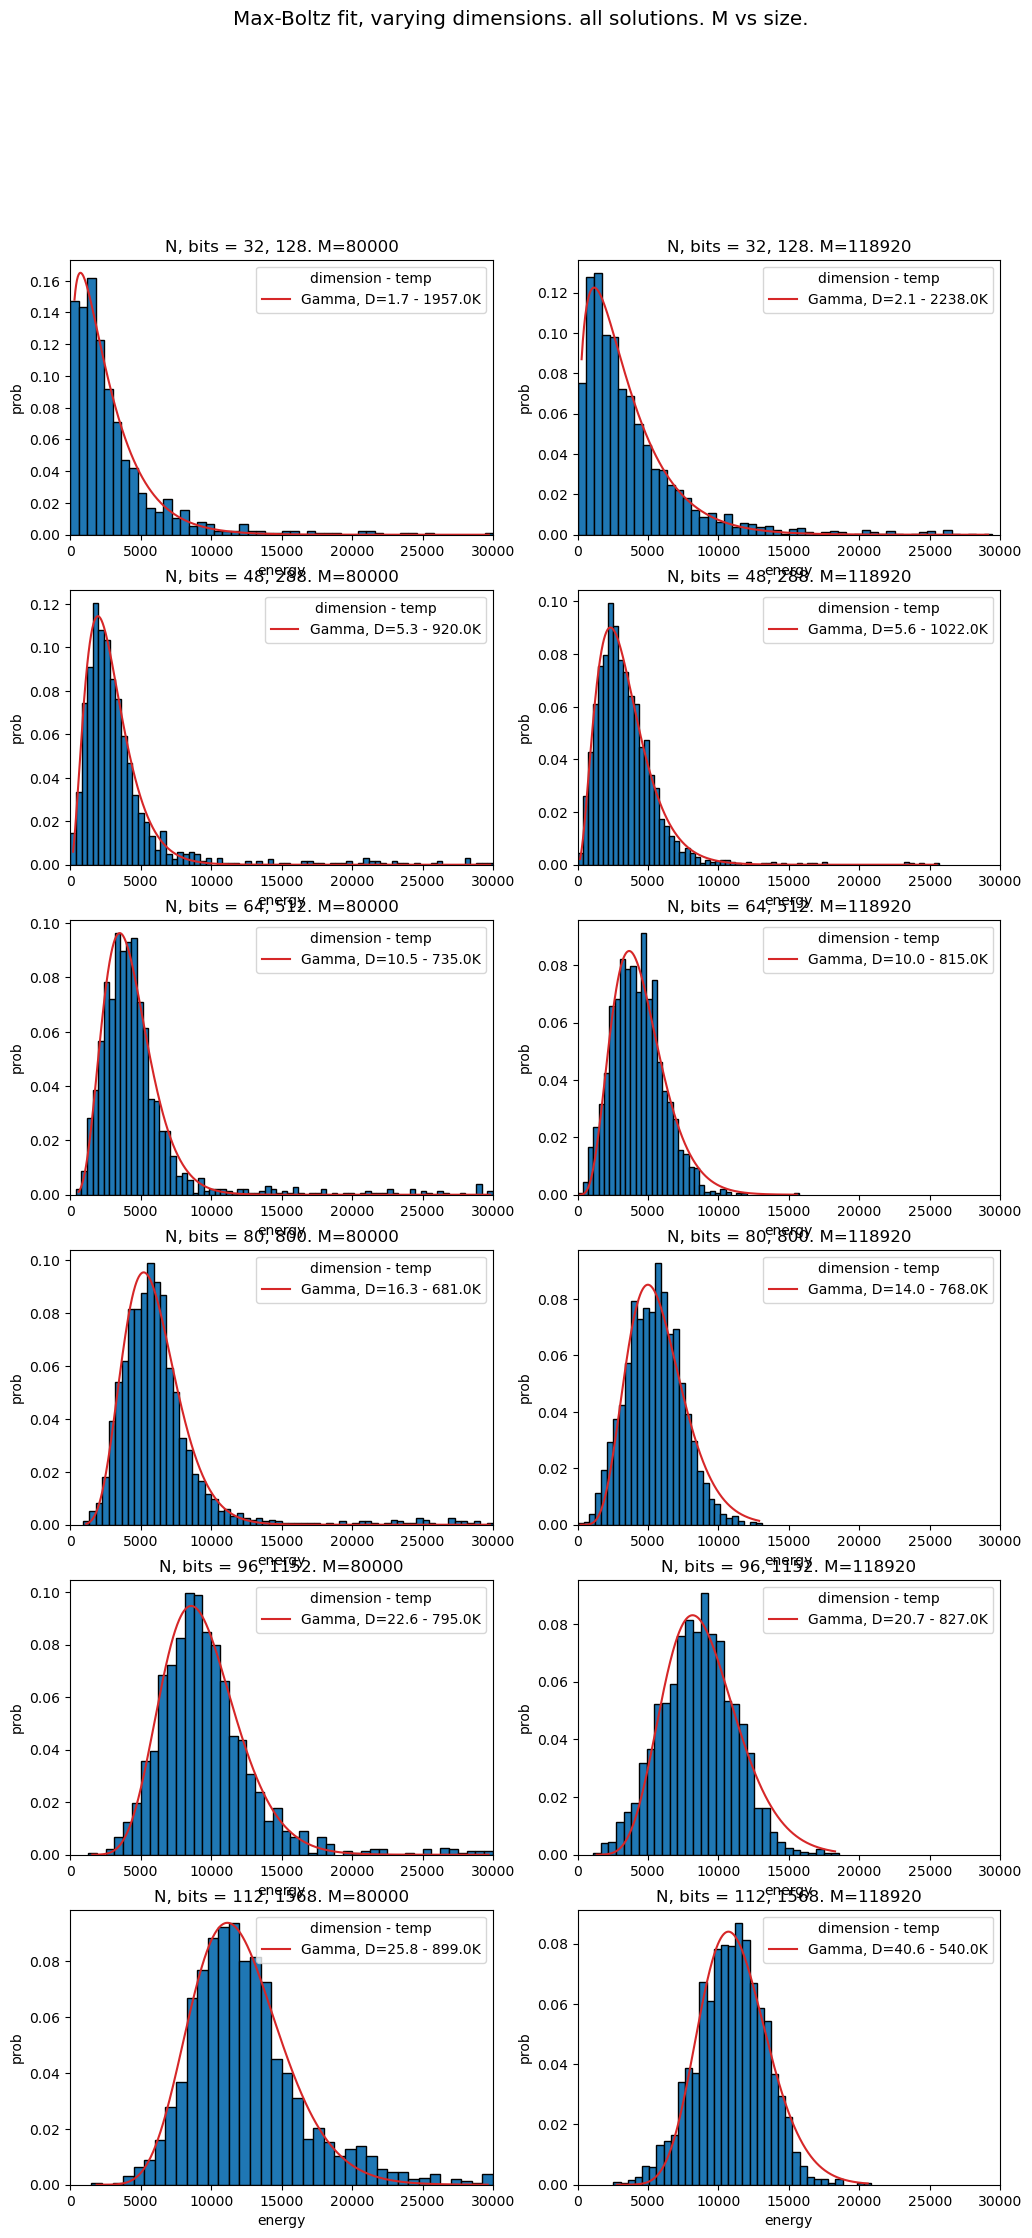

In [ ]:
### fit with data at different dimensions: plotting at different sizes and Ms
### Showing that MB fits well, Dimension depends mainly on the size of the problem (and not M), while fitted temperature depends on M too


def fit_maxboltz_nd(data_N, M, which, bins, plot_code, fit_lim, fig):
    '''
    Get histogram of energies, fit with MB and plot in specific position
    '''
    M_idx, M = nearest_to(Ms, M)
    # get data to plot
    ener = np.reshape(data_N[M_idx], newshape = (n_vseeds*n_dseeds*runs, 2)) #(n_dseeds*runs, 2) for single instance
    if which == 'valid':
        valids = ener[:, 1] == 0
        y_ener = ener[valids, 0]
    elif which == 'all':
        y_ener = ener[:, 0] + ener[:, 1]
    else:
        raise ValueError("energy histogram to plot not understood")
    
    # get histogram data
    counts, x_bins = np.histogram(y_ener, bins = bins, range = (0, 30_000))
    density = counts / counts.sum() # normalize to get a probability
    x_pos = (x_bins[1:] + x_bins[:-1])/2
    bin_width = x_bins[1]-x_bins[0]
    mask = density > 0 # filter out empty bins
    density, x_pos = density[mask], x_pos[mask]

    # plot
    ax = fig.add_subplot(*plot_code)
    ax.bar(x_pos, density, width = bin_width, edgecolor='k', linewidth=1)
    ax.set_ylabel("prob")
    ax.set_xlabel("energy")
    ax.set_xlim(0, 30000)
    plt.title(f"N, bits = {Ns[N_idx]}, {Ns[N_idx]*Ps[N_idx]}. M={M}")

    # FIT for distribution
    start, _ = nearest_to(x_pos, fit_lim[0])
    end, _ = nearest_to(x_pos, fit_lim[1])
    XS = np.linspace(x_pos[start], x_pos[end], 1000)
    f = lambda x, D, beta : gamma.pdf(x, (D+1)/2, loc = 0, scale = 1/beta) * bin_width
    coef, coef_var = sp.optimize.curve_fit(f, x_pos[start:end+1], density[start:end+1], p0 = [4, 1e-4])
    ax.plot(XS, f(XS, *coef), color = "C3", label = f"Gamma, D={np.round(coef[0], 1)} - {np.round(1/coef[1])}K")
    
    ax.legend(fontsize = 10, loc='best', title = "dimension - temp")
    return


which = 'all'
plot_Ms = [.8*10**5, 1.2*10**5]
plot_Ns_idxs = [2, 4,  6,  8, 10, 12]
bins = "auto"
fit_lim = [0, 30000]

fig = plt.figure(figsize=(12, 25))
fig.suptitle(f"Max-Boltz fit, varying dimensions. {which} solutions. M vs size.", fontsize="x-large")
for idx, N_idx in enumerate(plot_Ns_idxs):
    for M_idx, M in enumerate(plot_Ms):
        plot_code = (len(plot_Ns_idxs), len(plot_Ms), len(plot_Ms)*idx + M_idx + 1)
        fit_maxboltz_nd(data[N_idx], M, which, bins, plot_code, fit_lim, fig)
plt.show()